# HEAVY-COUGH 1D Feature analysis

In [393]:
import pandas as pd
import numpy as np
import glob
import os

file_list = glob.glob('both/*')
id_list = []
for file in file_list:
    id_list = id_list + [os.path.basename(file)]
    
audio_files=[]
for ids in id_list:
    audio_files = audio_files + ['bothaudio/'+ids+'/cough-heavy.wav']

all_files_js=[]
for ids in id_list:
    all_files_js = all_files_js + ['both/'+ids+'/cough-heavy_v2.json']

In [422]:
import matplotlib.pyplot as plt
import json as js
import librosa
import math
from scipy.stats import skew
from scipy.stats import kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

d = pd.read_csv('cough_params.csv')

def spectralcentroid(y,l, da, sr):
    spr = librosa.feature.spectral_centroid(y=y[math.ceil(da['start_{}'.format(l+1)]*sr):math.ceil(sr*da['end_{}'.format(l+1)])],sr=sr,n_fft=256, hop_length=128)
    return spr

def zcr(y,l,da,sr):
    spr =(librosa.feature.zero_crossing_rate(y=y[math.ceil(da['start_{}'.format(l+1)]*sr):math.ceil(sr*da['end_{}'.format(l+1)])],frame_length=256, hop_length=128))
    return spr

def rmse(y,l,da,sr):
    spr = (librosa.feature.rms(y=y[math.ceil(da['start_{}'.format(l+1)]*sr):math.ceil(sr*da['end_{}'.format(l+1)])],frame_length=256, hop_length=128))
    return spr

def spectralflatness(y,l,da,sr):
    spr = librosa.feature.spectral_flatness(y=y[math.ceil(da['start_{}'.format(l+1)]*sr):math.ceil(sr*da['end_{}'.format(l+1)])],n_fft=256, hop_length=128)
    return spr

def spectralrolloff(y,l,da,sr):
    spr =  librosa.feature.spectral_rolloff(y=y[math.ceil(da['start_{}'.format(l+1)]*sr):math.ceil(sr*da['end_{}'.format(l+1)])],sr=sr,n_fft=256, hop_length=128)
    return spr
    

def feature_function(feature_name, tag):
    d = pd.read_csv('cough_params.csv')
    globals()['data_{}'.format(tag)]=pd.DataFrame(columns=['ID','status','{}_mean'.format(tag),'{}_median'.format(tag),'{}_std'.format(tag),'{}_var'.format(tag),'{}_min'.format(tag),'{}_max'.format(tag),'{}_quartile25'.format(tag),'{}_quartile75'.format(tag),'{}_kurtosis'.format(tag),'{}_skewness'.format(tag)])
    globals()['data_{}'.format(tag)][['ID','status']] = d[['ID','status']]
    globals()['{}_file'.format(tag)] = open('{}_averages.txt'.format(tag),'a+')
    
    for idno in range(len(id_list)):

        with open(all_files_js[idno]) as jsonfile:
            da = js.load(jsonfile)
        del da['vol']
        del da['stage']
        del da['cont']
        del da['annotator_name']
        del da['quality']

        avg = np.zeros((20))

        y, sr = librosa.load(audio_files[idno], sr = 16000)
        for l in range(int(len(da)/2)):
            if(feature_name == 'spectral_centroid'):
                spr = spectralcentroid(y,l,da,sr)
            elif(feature_name == 'spectral_flatness'):
                spr = spectralflatness(y,l,da,sr)
            elif(feature_name == 'rmse'):
                spr = rmse(y,l,da,sr)
            elif(feature_name == 'zcr'):
                spr = zcr(y,l,da,sr)
            elif(feature_name == 'spectral_rolloff'):
                spr = spectralrolloff(y,l,da,sr)
            else:
                print('wrong feature input')
                break
                
                
            
            if(len(avg)<len(spr[0])):
                d=len(spr[0])-len(avg)
                zc= np.pad(avg, pad_width =(0,d), mode ='constant')[0]
                avg = (zc+spr[0])*0.5     
            elif (len(spr[0])<len(avg)):
                d= len(avg)-len(spr[0])
                zc =np.pad(spr[0], pad_width=(0,d), mode='constant')   
                avg = (zc+avg)*0.5
            else:
                avg =(spr[0]+avg)*0.5


        globals()['data_{}'.format(tag)]['{}_mean'.format(tag)][idno]=np.average(avg)
        globals()['data_{}'.format(tag)]['{}_median'.format(tag)][idno]=np.median(avg)
        globals()['data_{}'.format(tag)]['{}_std'.format(tag)][idno]=np.std(avg)
        globals()['data_{}'.format(tag)]['{}_var'.format(tag)][idno]=np.var(avg)
        globals()['data_{}'.format(tag)]['{}_min'.format(tag)][idno]=np.amin(avg)
        globals()['data_{}'.format(tag)]['{}_max'.format(tag)][idno]=np.amax(avg)
        globals()['data_{}'.format(tag)]['{}_quartile25'.format(tag)][idno]=np.quantile(avg,0.25)
        globals()['data_{}'.format(tag)]['{}_quartile75'.format(tag)][idno]=np.quantile(avg,0.75)
        globals()['data_{}'.format(tag)]['{}_kurtosis'.format(tag)][idno]=kurtosis(avg)
        globals()['data_{}'.format(tag)]['{}_skewness'.format(tag)][idno]=skew(avg)

        globals()['{}_file'.format(tag)].write(id_list[idno])
        globals()['{}_file'.format(tag)].write(':\t')
        globals()['{}_file'.format(tag)].write(str(list(avg)))
        globals()['{}_file'.format(tag)].write('\n')


    globals()['col_{}'.format(tag)]=['{}_mean'.format(tag),'{}_median'.format(tag),'{}_std'.format(tag),'{}_var'.format(tag),'{}_min'.format(tag),'{}_max'.format(tag),'{}_quartile25'.format(tag),'{}_quartile75'.format(tag),'{}_kurtosis'.format(tag),'{}_skewness'.format(tag)]
    globals()['data_{}'.format(tag)].to_csv('{}features.csv'.format(tag))
    globals()['data_{}'.format(tag)][globals()['col_{}'.format(tag)]] =(globals()['data_{}'.format(tag)][globals()['col_{}'.format(tag)]]).astype(float)
    globals()['{}_matrix'.format(tag)] = globals()['data_{}'.format(tag)][globals()['col_{}'.format(tag)]].to_numpy()  
    np.save('{}_featurematrix.npy'.format(tag),globals()['{}_matrix'.format(tag)])
    #pklfile = open('{}_picklefile.pkl'.format(tag), 'wb')
    #pkl.dump(globals()['{}_file'.format(tag)],pklfile)
    
def plotavgfunction(tag, feature_name):
    plt.figure(figsize=(20,20))
    plt.plot(globals()['data_{}'.format(tag)]['{}_mean'.format(tag)])
    plt.title('Plotting average distribution of {}'.format(feature_name))
             
    
def corrfunction(feature_name,data,col):
    plt.figure(figsize=(20,20))
    sns.heatmap(data[col].corr(), annot=True, annot_kws={"fontsize":18})  
    sns.set(font_scale=2)
    plt.title('{} features correlation matrix'.format(feature_name))
    plt.savefig('{}_correlationmatrixfeatures.png'.format(feature_name))
    
def pairplotfunction(feature_name,data):
    sns.pairplot(data, kind="scatter", hue="status")
    plt.savefig('SpectralFlatnessfeaturesrelation.png')
    
def PCAfunction(tag,feature_name):
    globals()['{}_scaled'.format(tag)] = StandardScaler().fit_transform(globals()['{}_matrix'.format(tag)])
    globals()['{}_scaled_df'.format(tag)] = pd.DataFrame(sr_scaled, columns=globals()['col_{}'.format(tag)])
    pca = PCA(n_components=10)
    principal_comps=pca.fit_transform(globals()['{}_scaled'.format(tag)])
    globals()['{}_pca_df'.format(tag)] = pd.DataFrame(data=principal_comps, columns=['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7','PCA8','PCA9','PCA10'])
    globals()['pcavar_{}'.format(tag)]=pca.explained_variance_ratio_
    globals()['ev_{}'.format(tag)] = pca.singular_values_
    plt.figure(figsize=(20,10))
    plt.grid(True)
    plt.plot(globals()['ev_{}'.format(tag)] ,color='k', marker='o')
    for num in range(len(globals()['ev_{}'.format(tag)] )):
        plt.annotate(round(globals()['ev_{}'.format(tag)][num],2),(num, globals()['ev_{}'.format(tag)][num]))
    plt.title('Eigen values for {} features'.format(feature_name))
    plt.savefig('PCA{}EigVal.png'.format(tag))
    plt.show()
    
def PCAvar(tag, feature_name):
    plt.figure(figsize=(20,10))
    plt.grid(True)
    plt.plot(globals()['pcavar_{}'.format(tag)],color='k', marker='o')
    for num in range(len(globals()['pcavar_{}'.format(tag)])):
        plt.annotate(round(globals()['pcavar_{}'.format(tag)][num],3),(num,globals()['pcavar_{}'.format(tag)][num]))
    plt.title('variance explained by each PCA component for {}.'.format(tag))
    plt.savefig('PCA{}var.png'.format(tag))
    plt.show()


1 features calculated are:- ZCR, spectral Centroid, RMSE, Spectral Flatness, Spectral RollOff, MFCCs and delta-MFCCs

The 1D features (time series) (RMSE, ZCR, SR, SF, SC) extracted from the annotations boundaries for each ID is averaged, and the statistical parameters of these averaged features are extracted, namely:-
1)Mean
2)Median
3)Standard Deviation
4)Variance
5)min value
6)Max value
7)25% quantile
8)75% quantile
9)kurtosis
10)Skewness
We get a 100* 10feature matrix for each 1D feature.


For MFCC and delta-MFCC, first 13 coefficeints are averaged for each ID. Each of these feature matrices form 100* 13 feature matrix

Combing all these features, we have a feature meatrix of 100* 76. PCA was performed on it, and the variance was plotted.

The correlation plot shows the correaltion values between different statistical features.

The pairplot functions show the relationship between the data points of two variables for a given ID.

## Spectral Centroid

In [351]:
feature_function('spectral_centroid','sc')

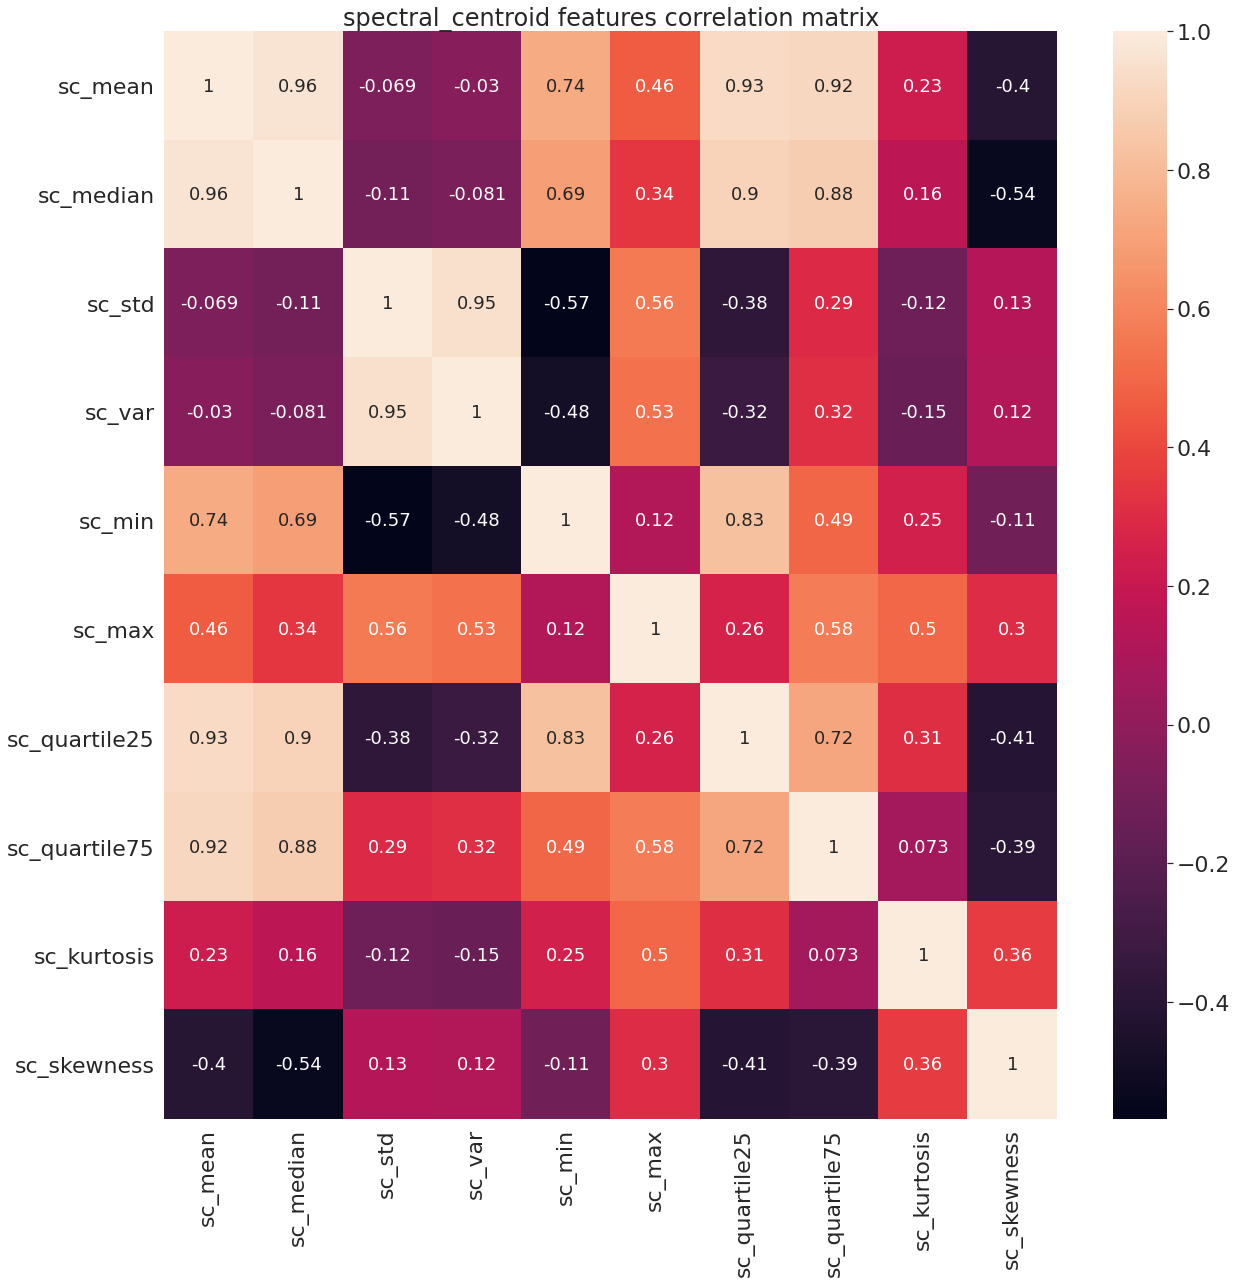

In [334]:
corrfunction('spectral_centroid',data_sc,col_sc)

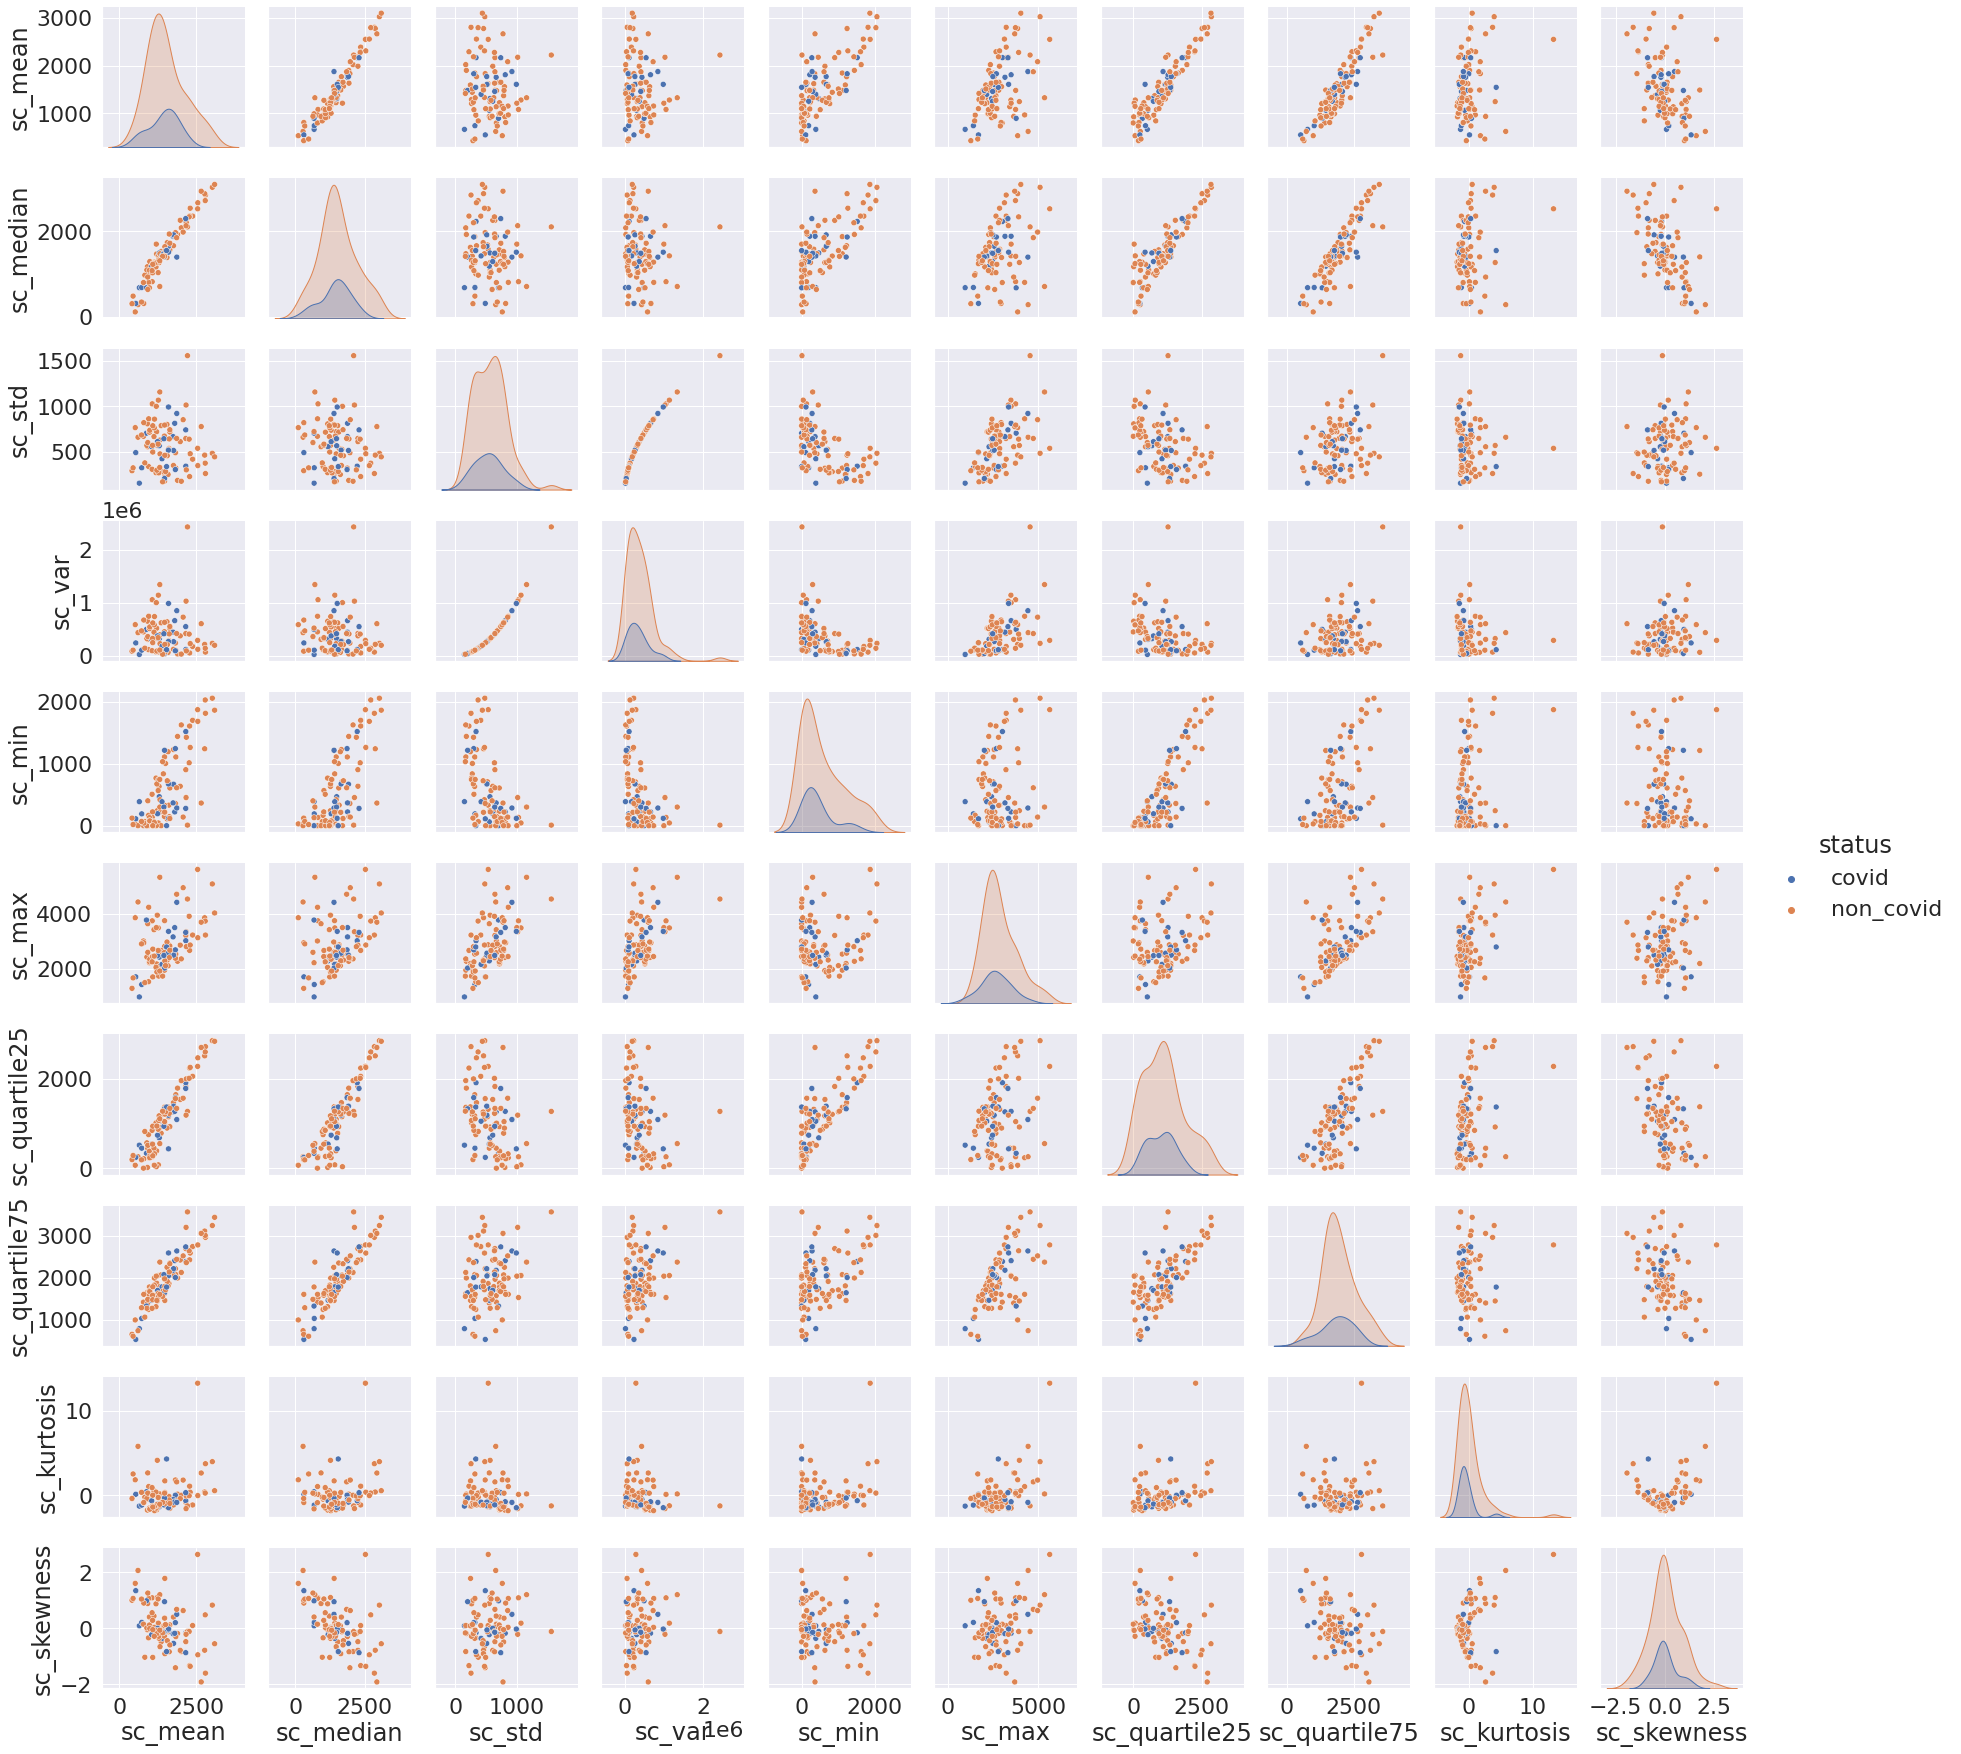

In [338]:
pairplotfunction('spectral_centroid',data_sc)

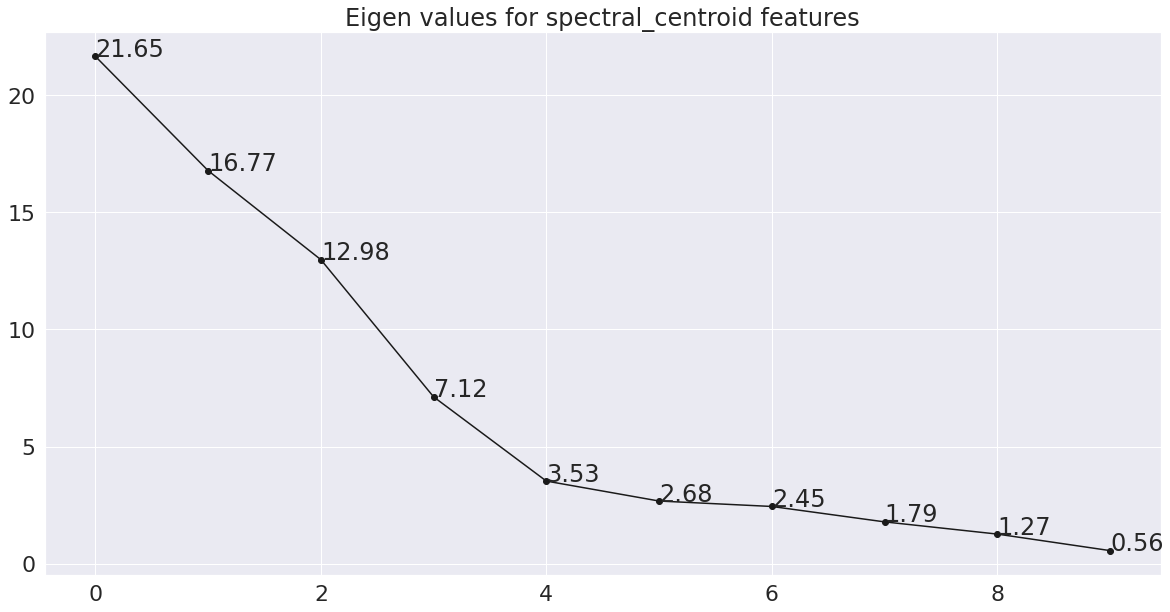

In [352]:
PCAfunction('sc','spectral_centroid')

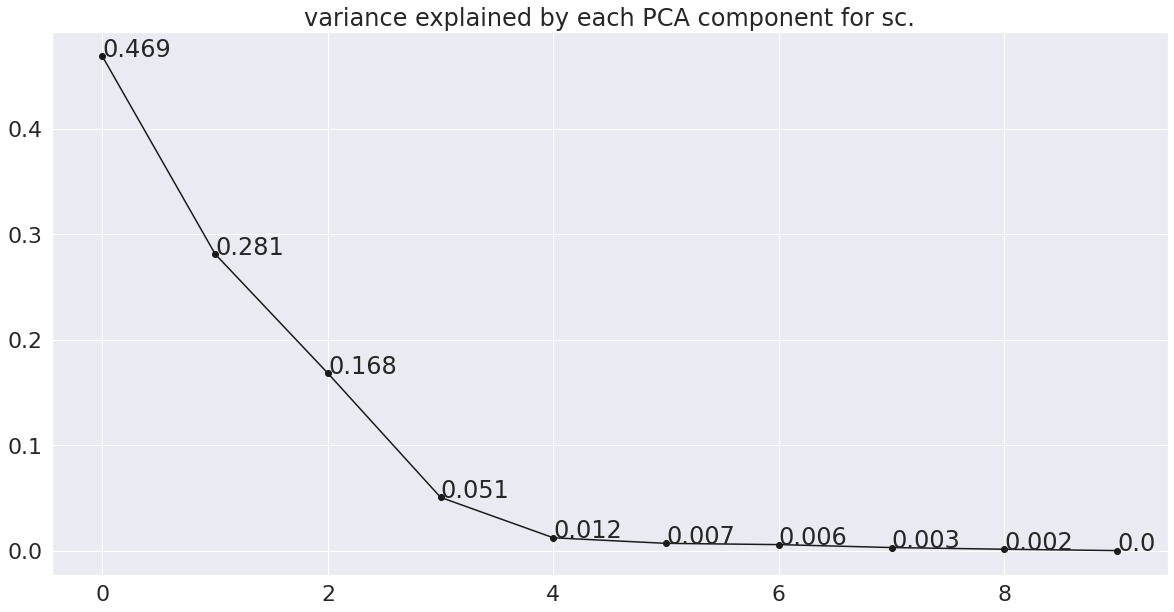

In [357]:
PCAvar('sc', 'spectral_centroid')

For the Spectral Centroid features nearly 75% of the variance is explained by the first two PCA components. 

## Spectral Flatness

In [359]:
feature_function('spectral_flatness','sf')

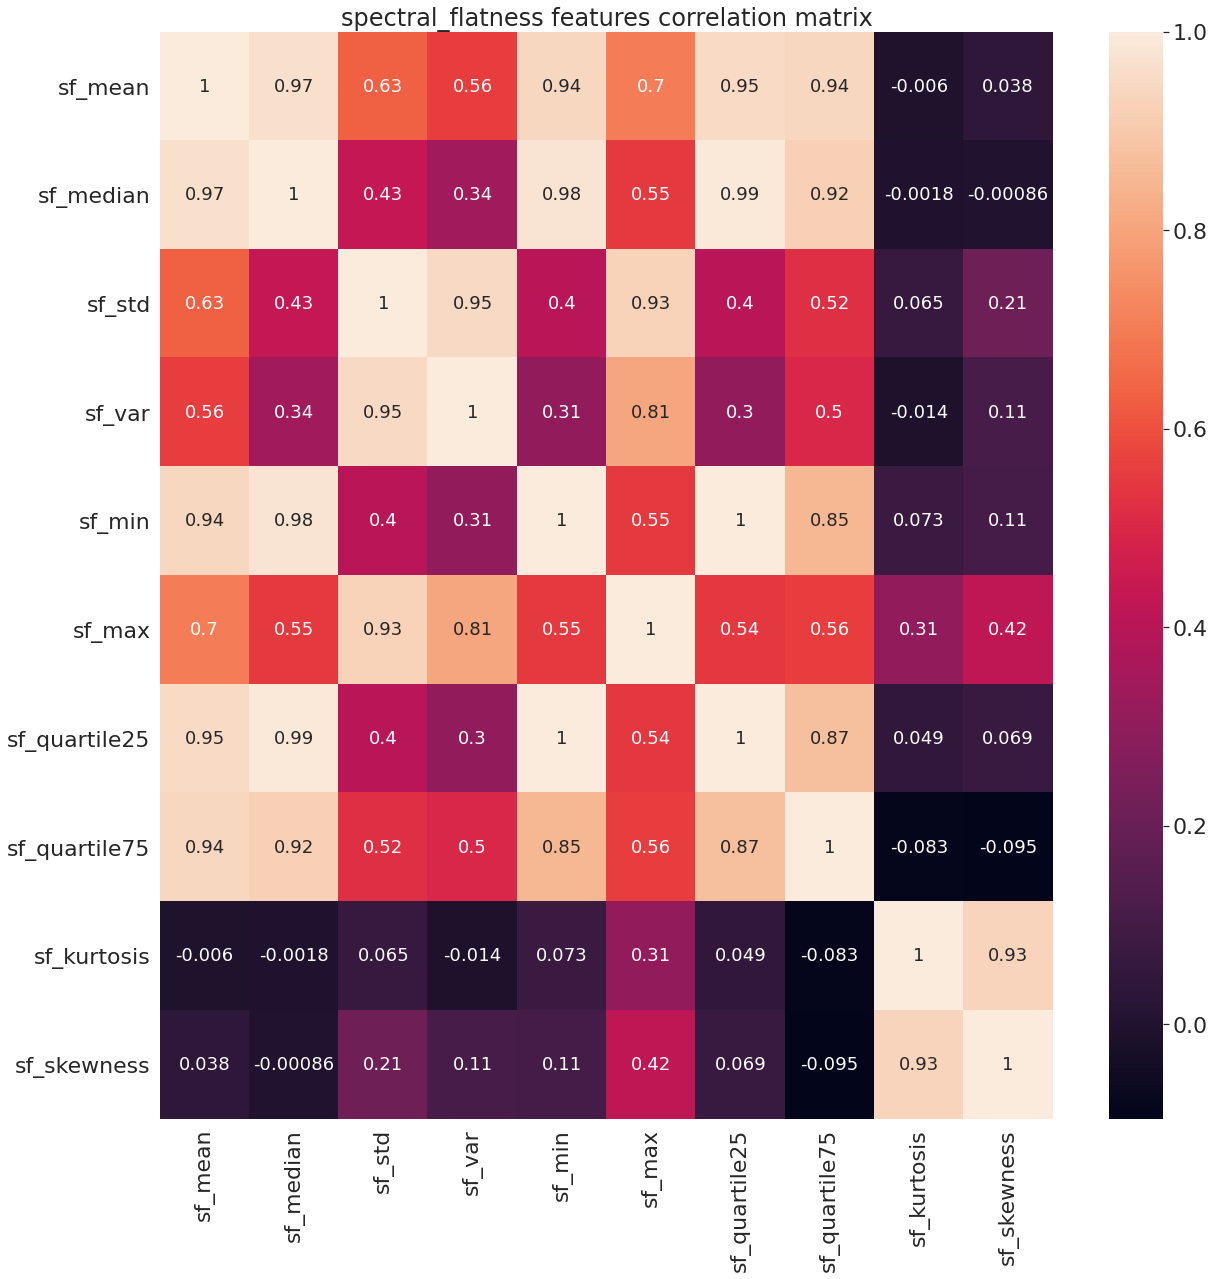

In [360]:
corrfunction('spectral_flatness',data_sf,col_sf)

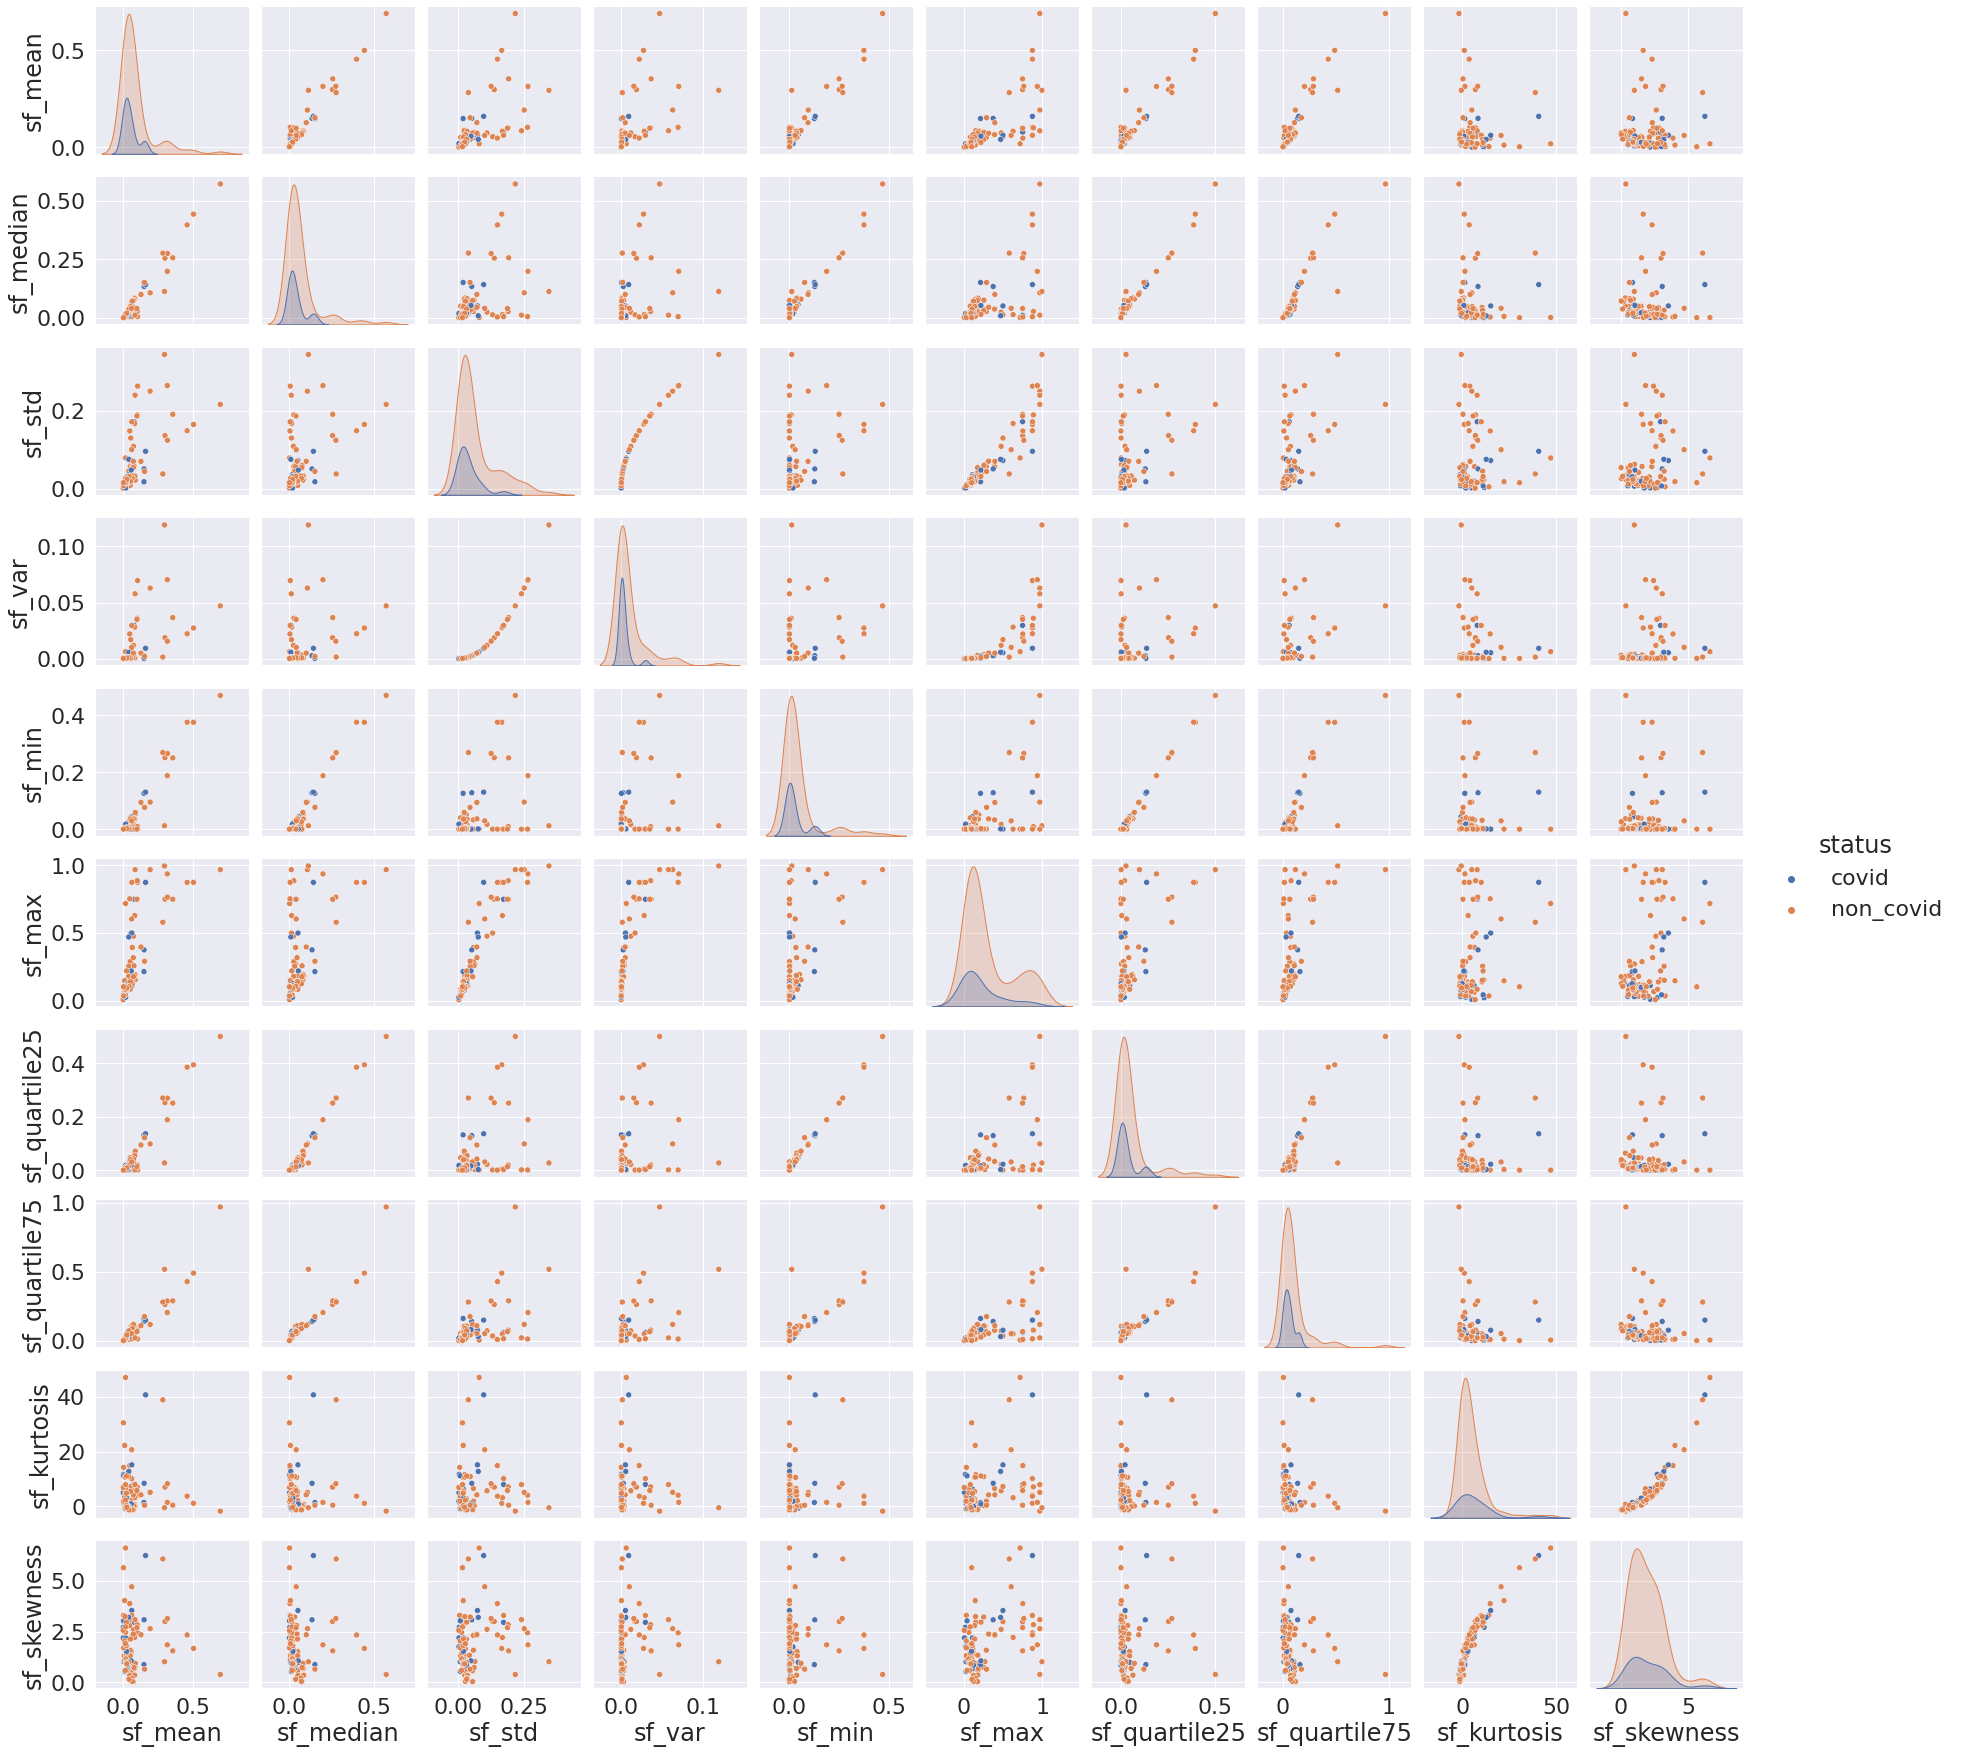

In [361]:
pairplotfunction('spectral_flatness',data_sf)

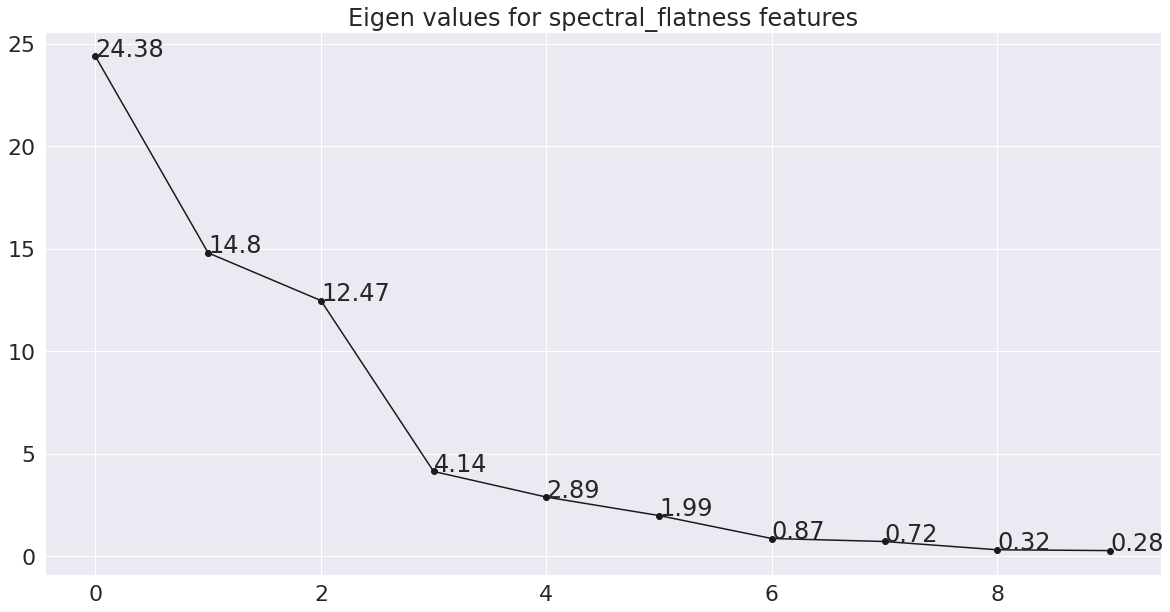

In [362]:
PCAfunction('sf','spectral_flatness')

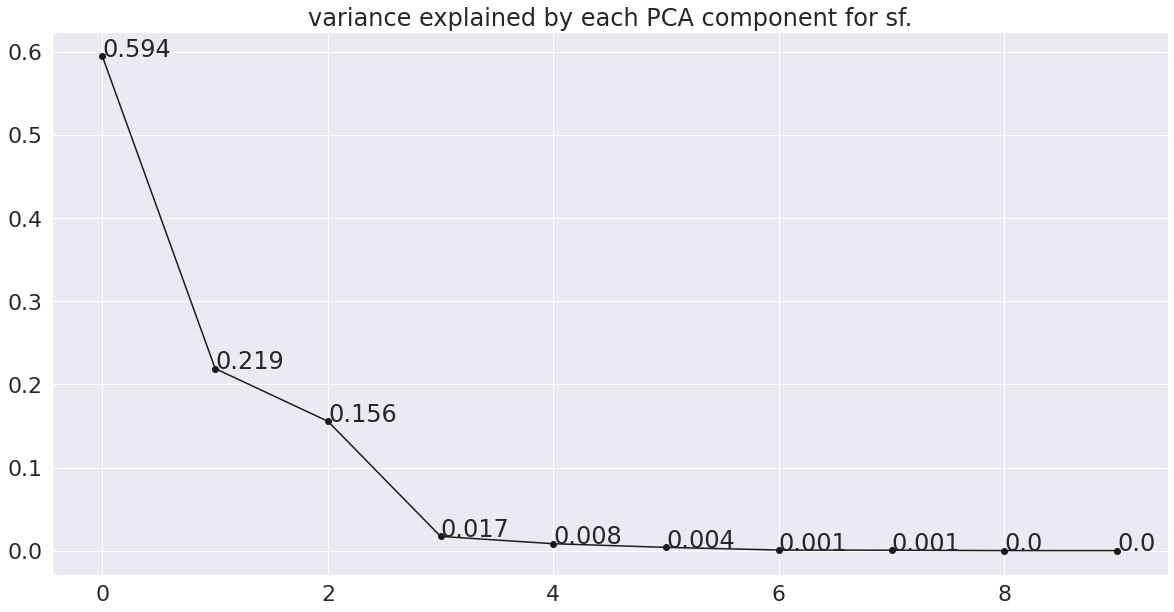

In [368]:
PCAvar('sf', 'spectral_flatness')

More than 80% of the variations is explained by the first two factors.

## Spectral RollOff

In [364]:
feature_function('spectral_rolloff','sr')

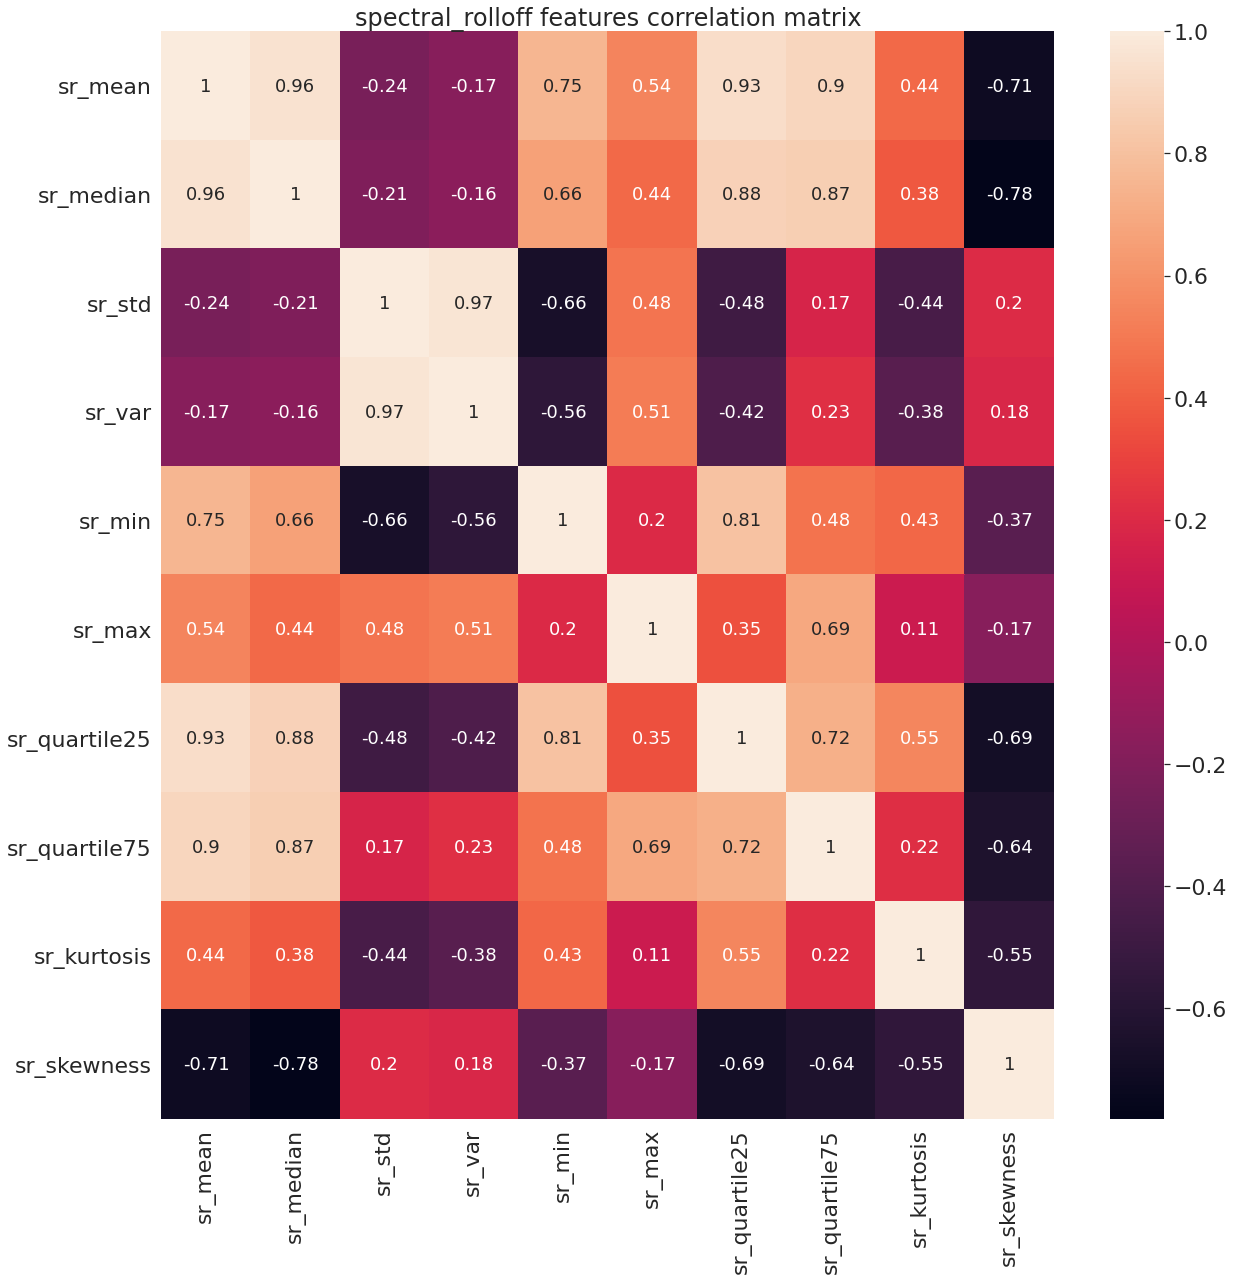

In [365]:
corrfunction('spectral_rolloff',data_sr,col_sr)

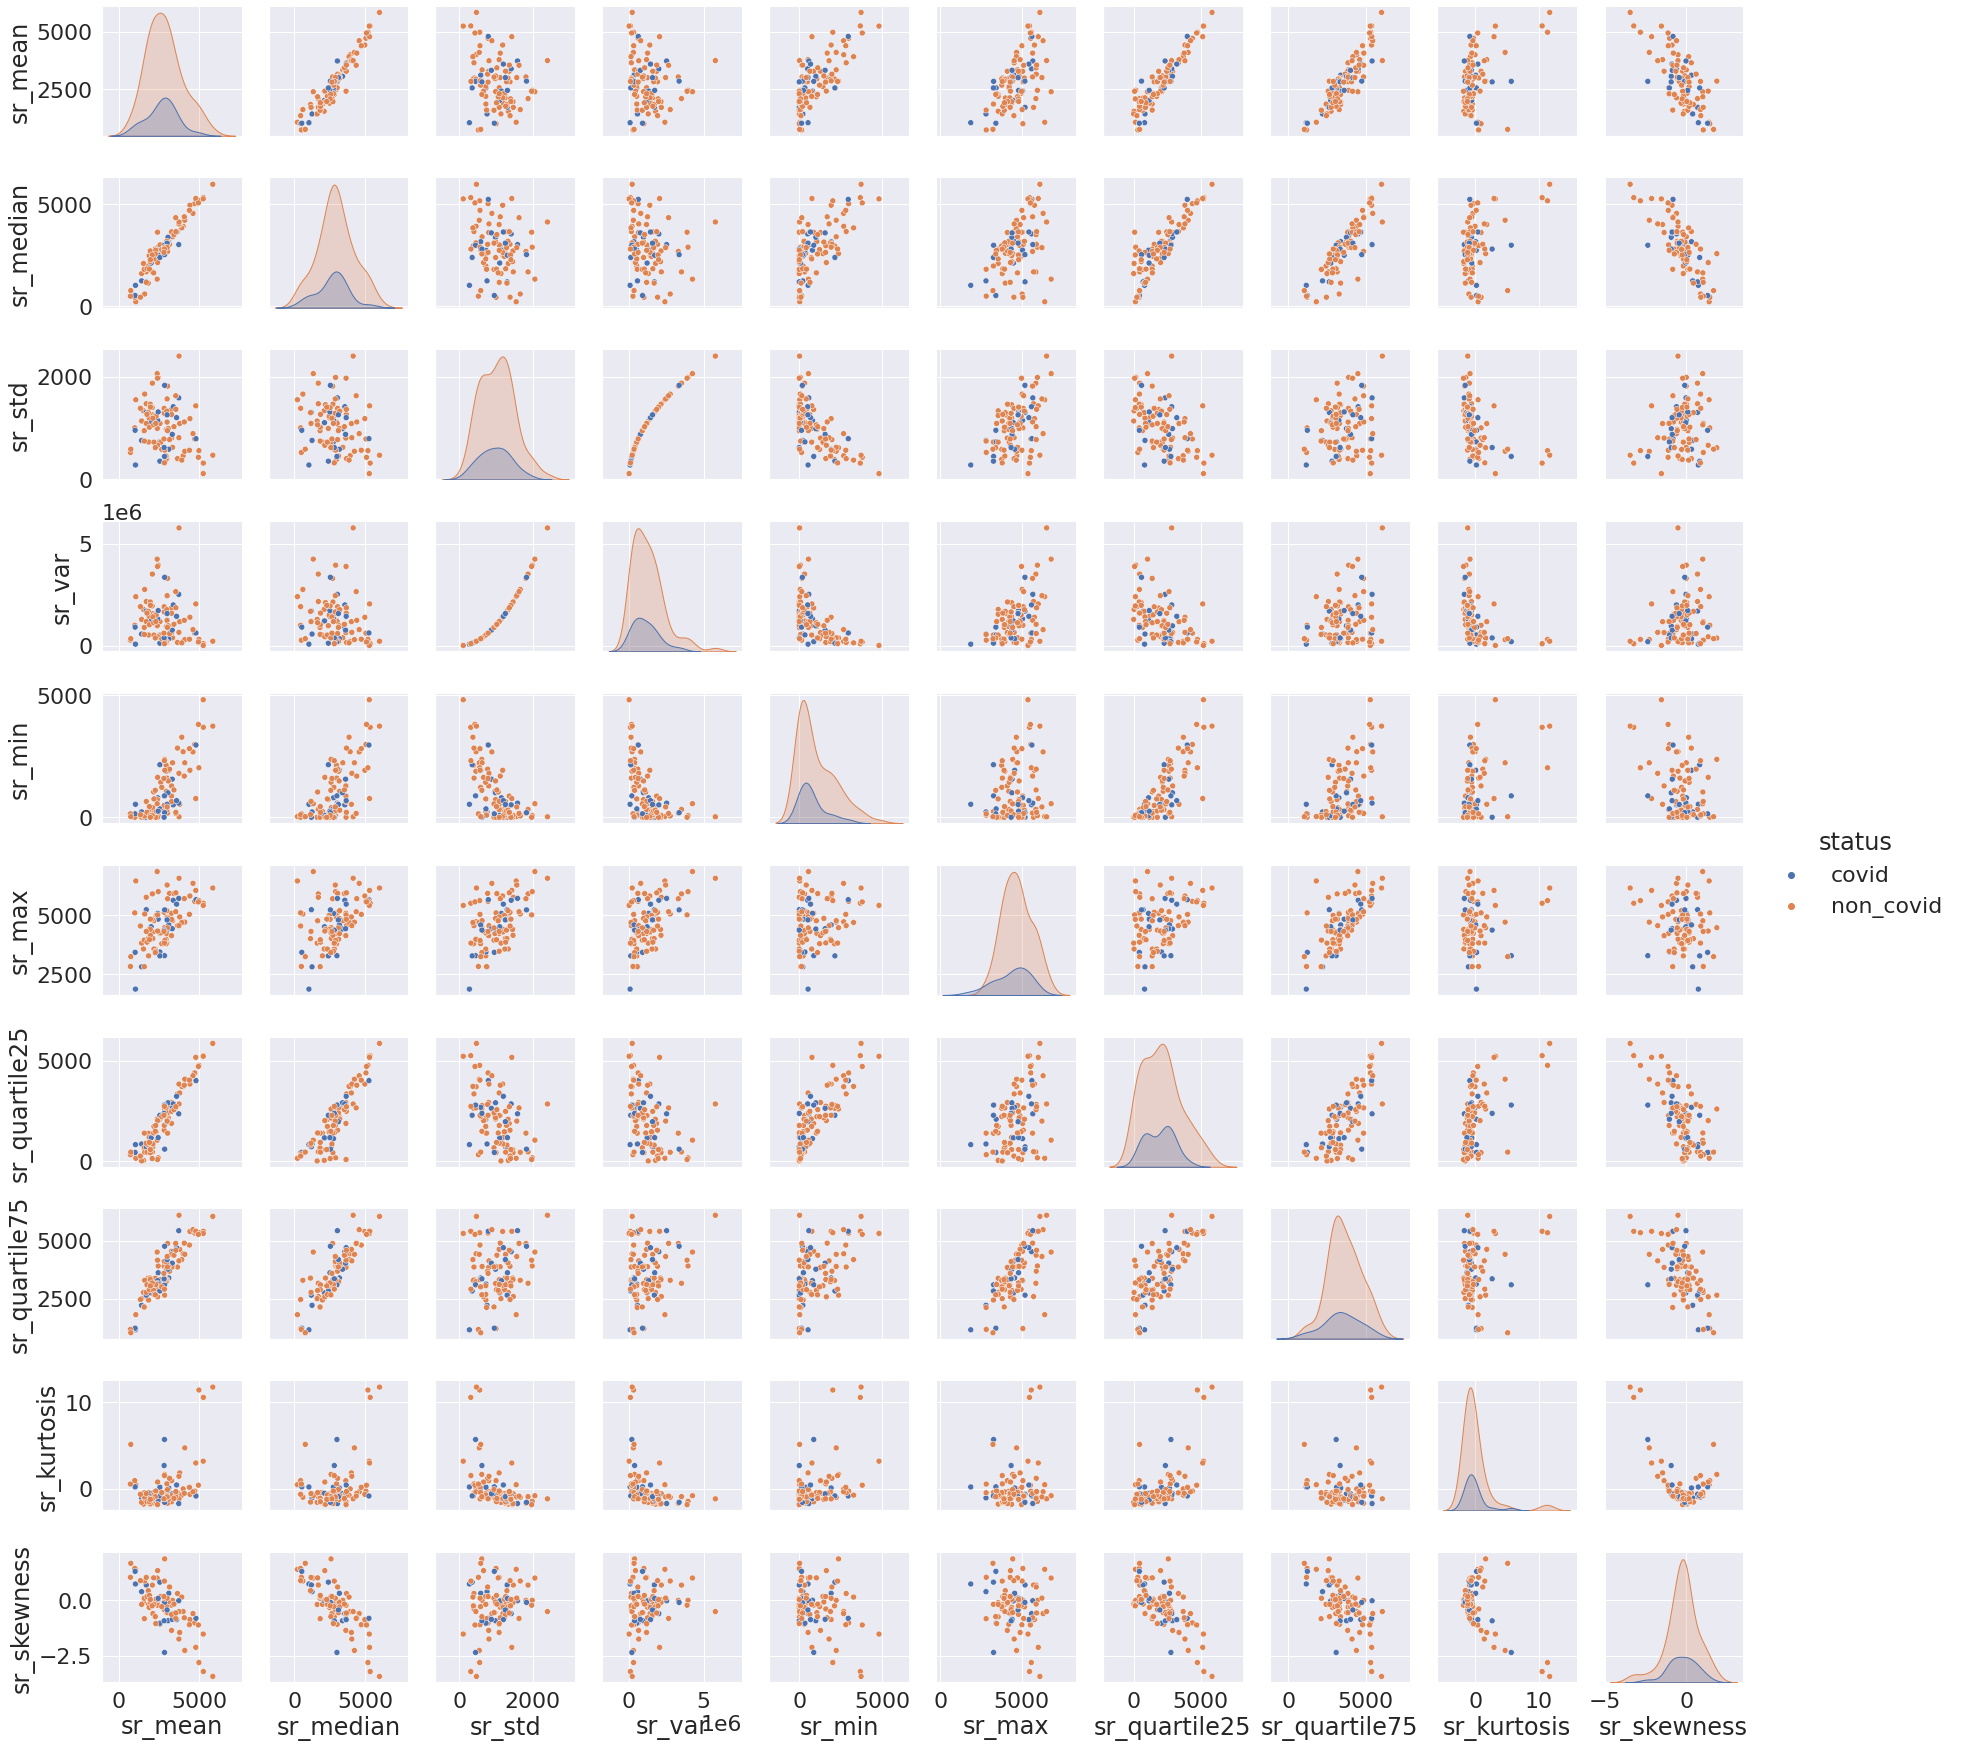

In [366]:
pairplotfunction('spectral_rolloff',data_sr)

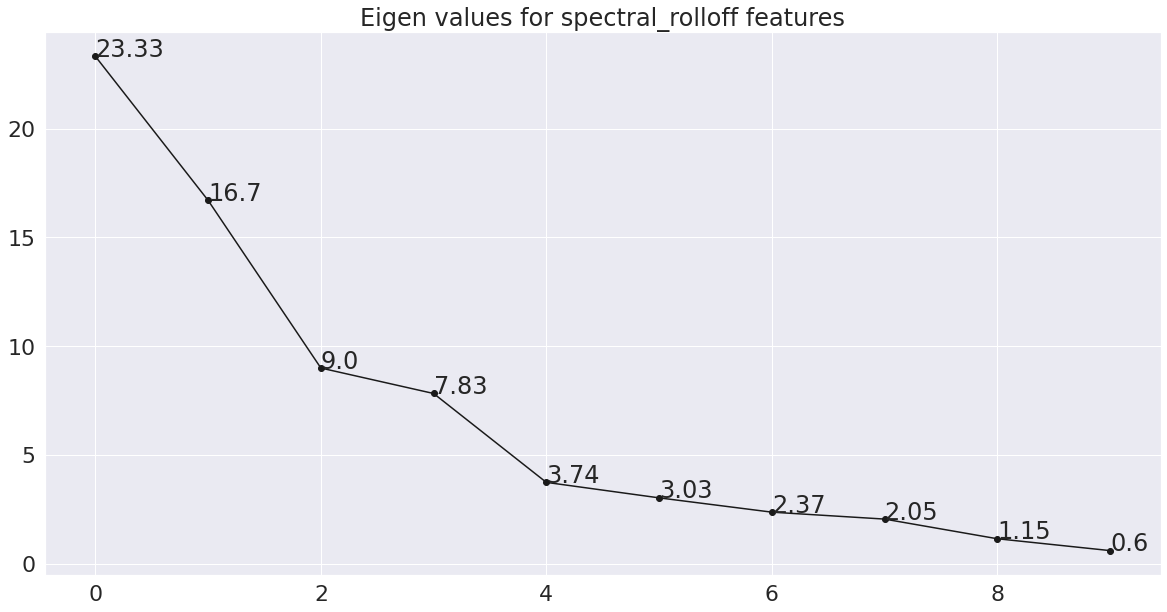

In [367]:
PCAfunction('sr','spectral_rolloff')

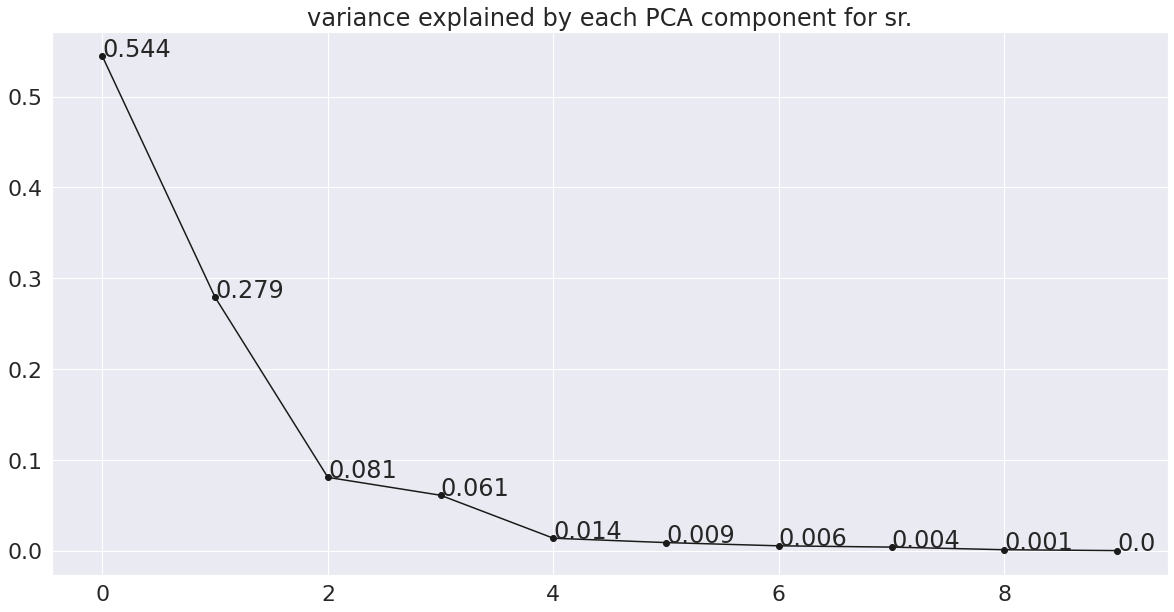

In [369]:
PCAvar('sr', 'spectral_rolloff')

Nearly 82% of the variance is explained by the first two components.

## ZCR

In [371]:
feature_function('zcr','zcr')

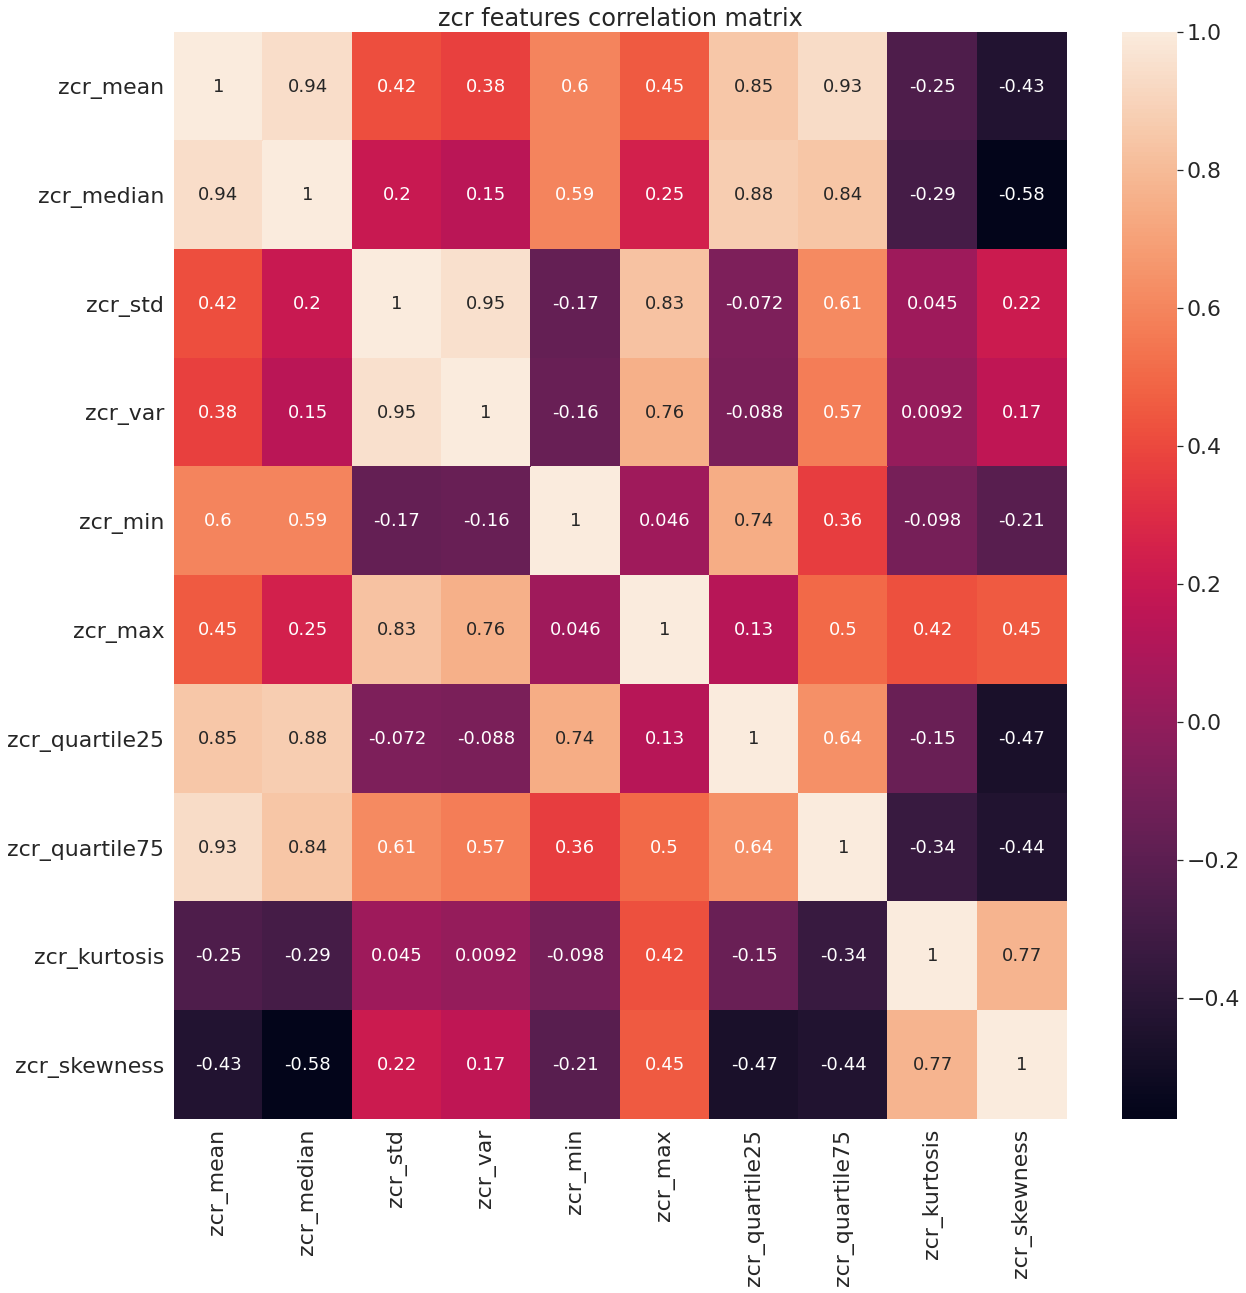

In [372]:
corrfunction('zcr',data_zcr,col_zcr)

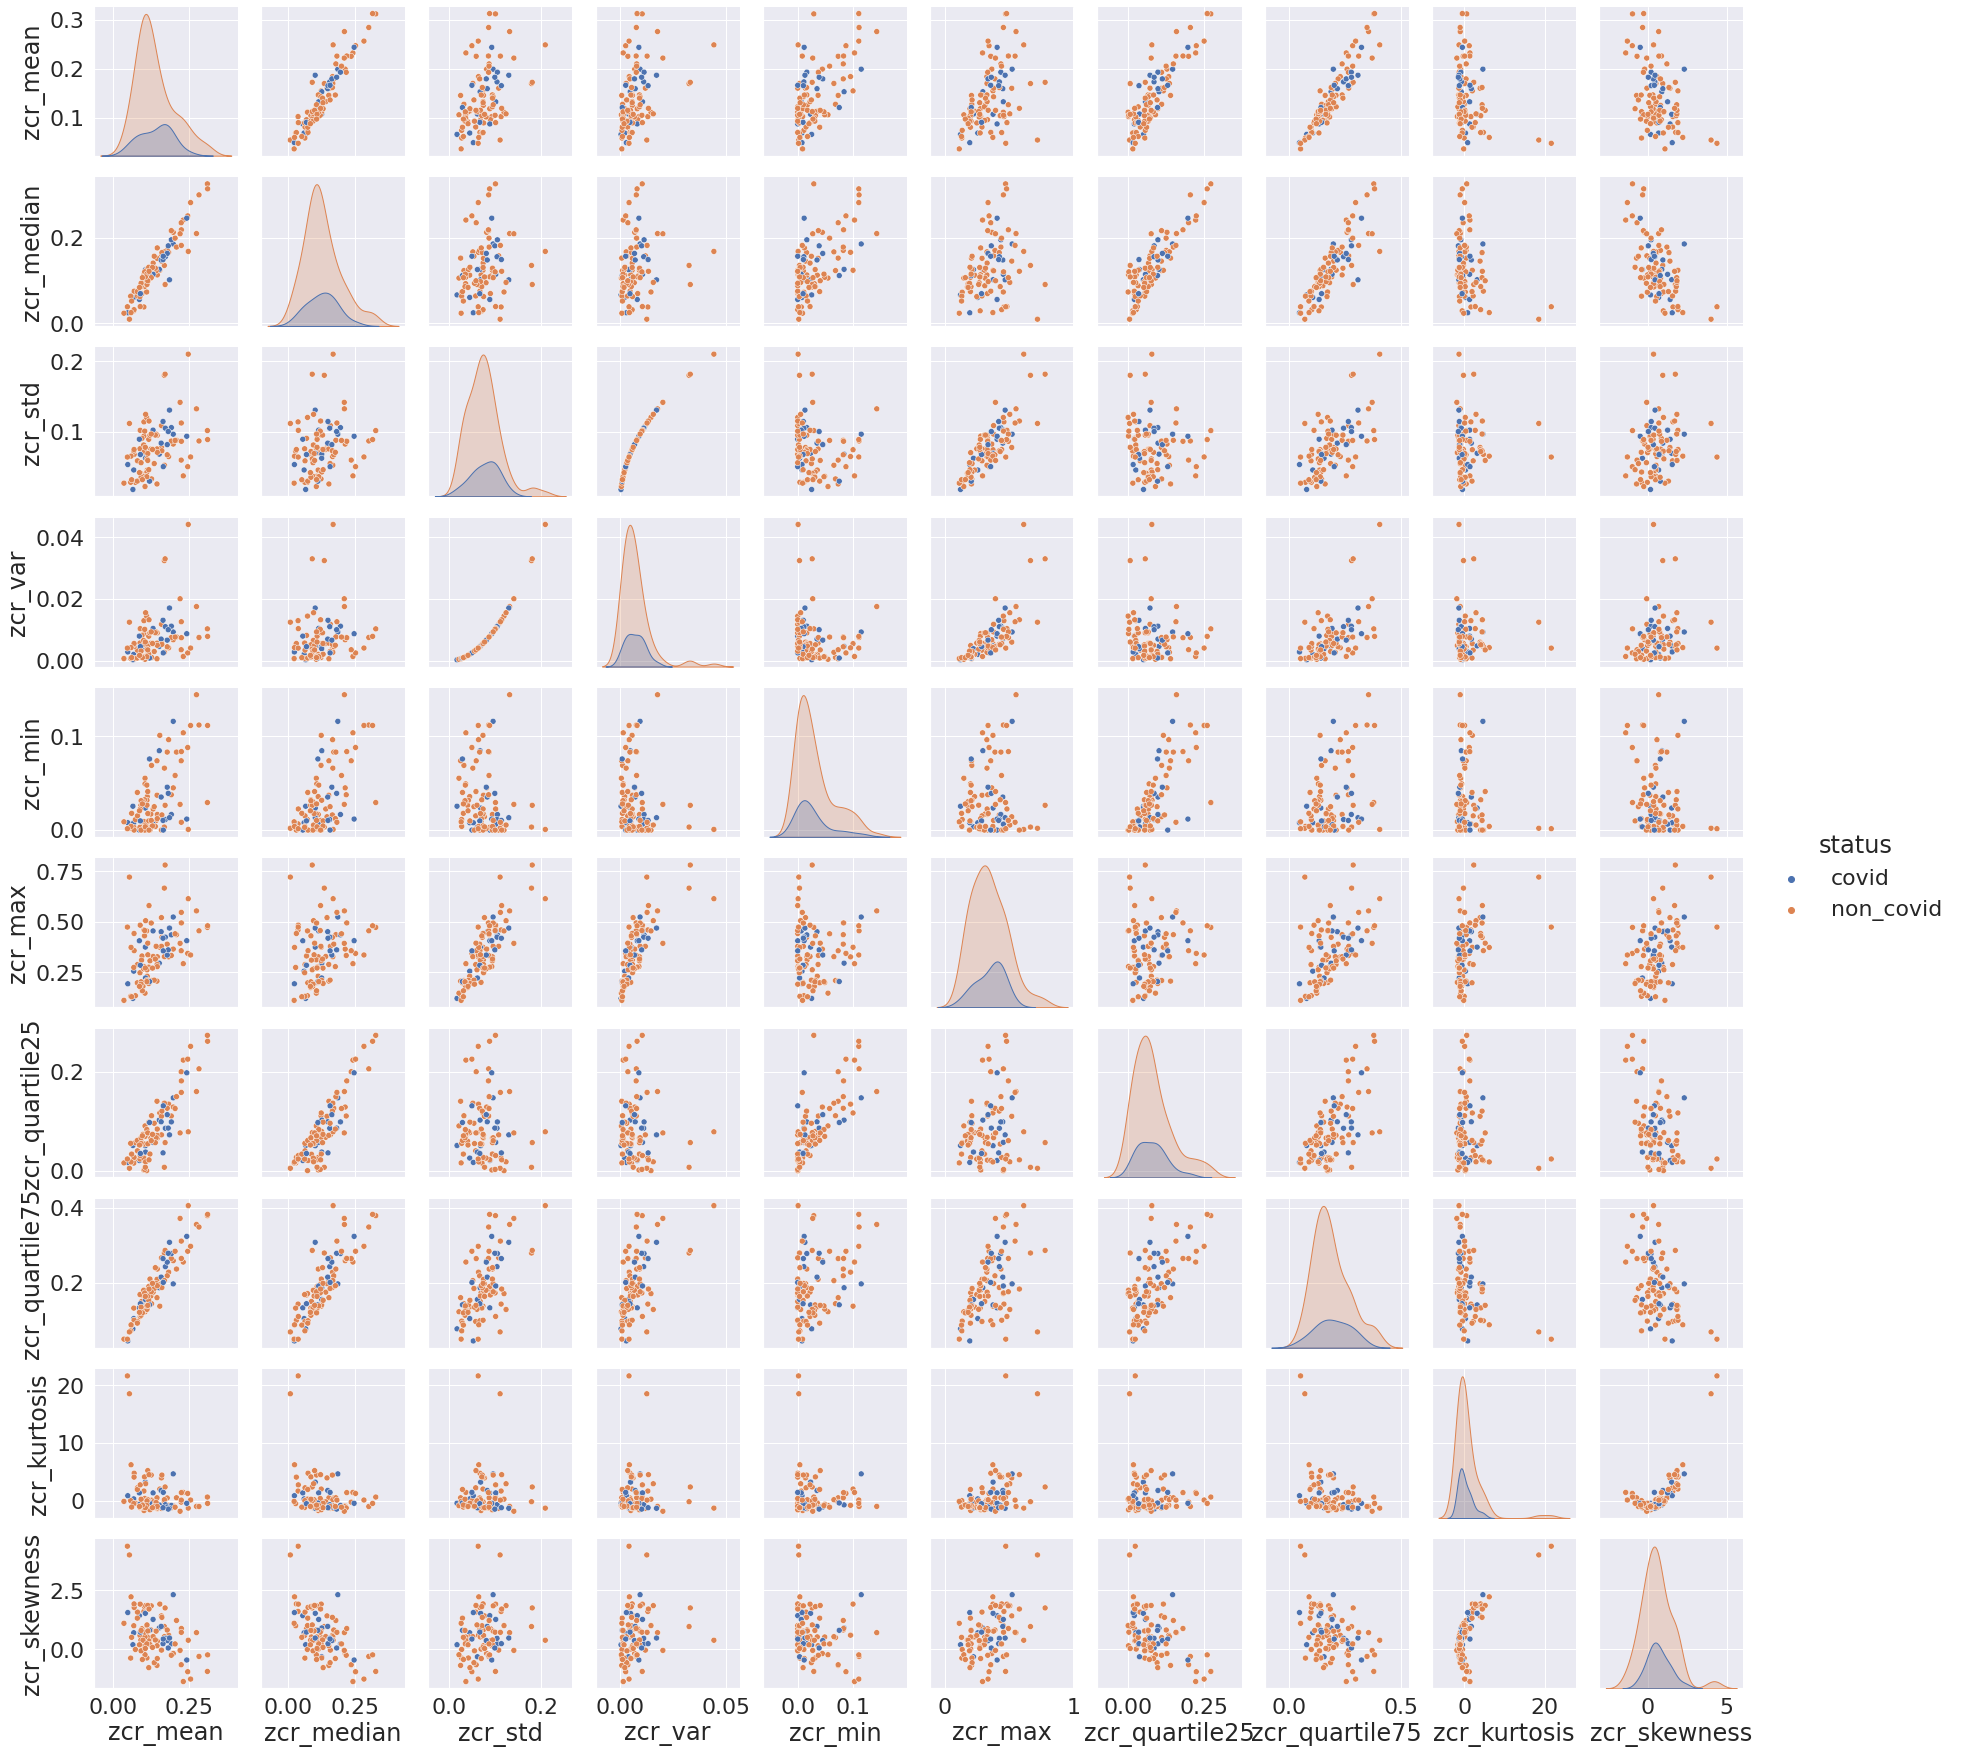

In [373]:
pairplotfunction('zcr',data_zcr)

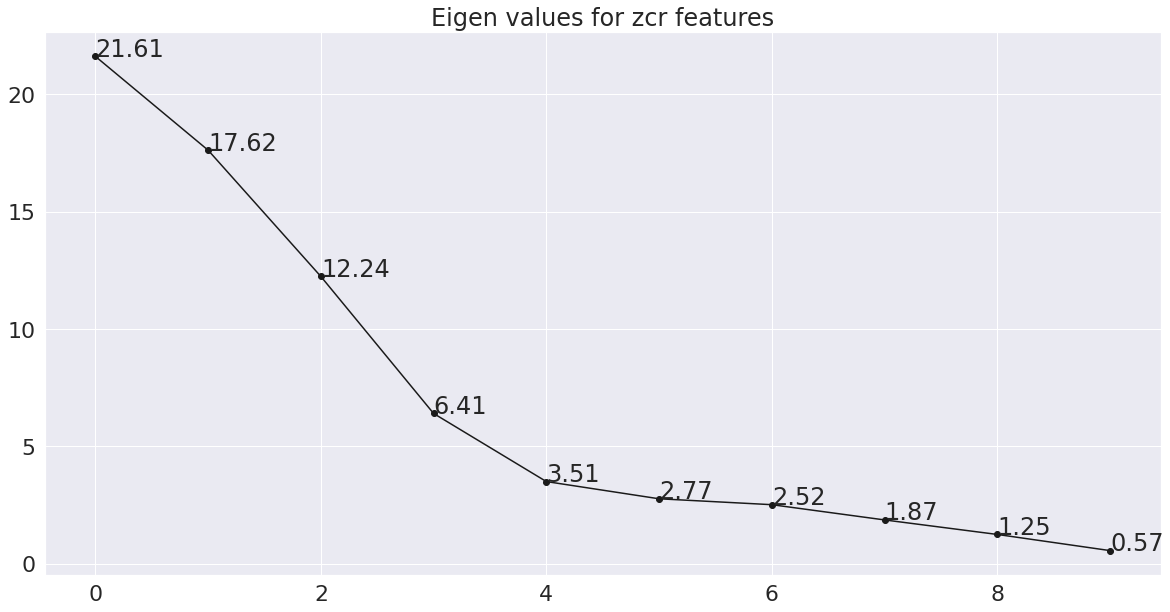

In [374]:
PCAfunction('zcr','zcr')

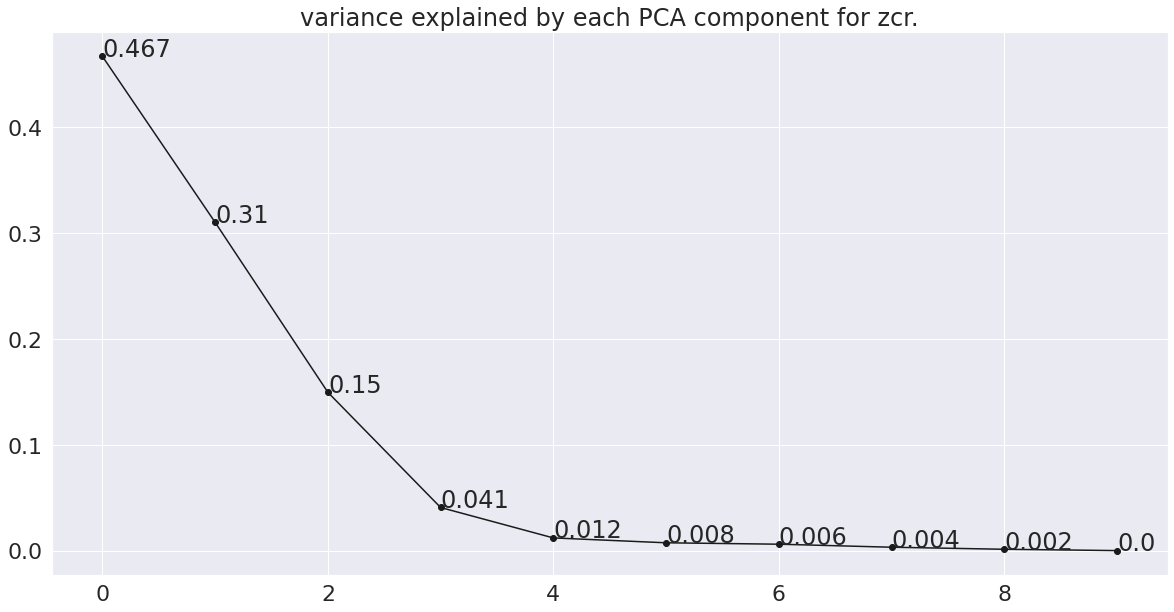

In [375]:
PCAvar('zcr', 'zcr')

Nearly 77% of the variance is explained by the first two components

## RMSE

In [377]:
feature_function('rmse','rmse')

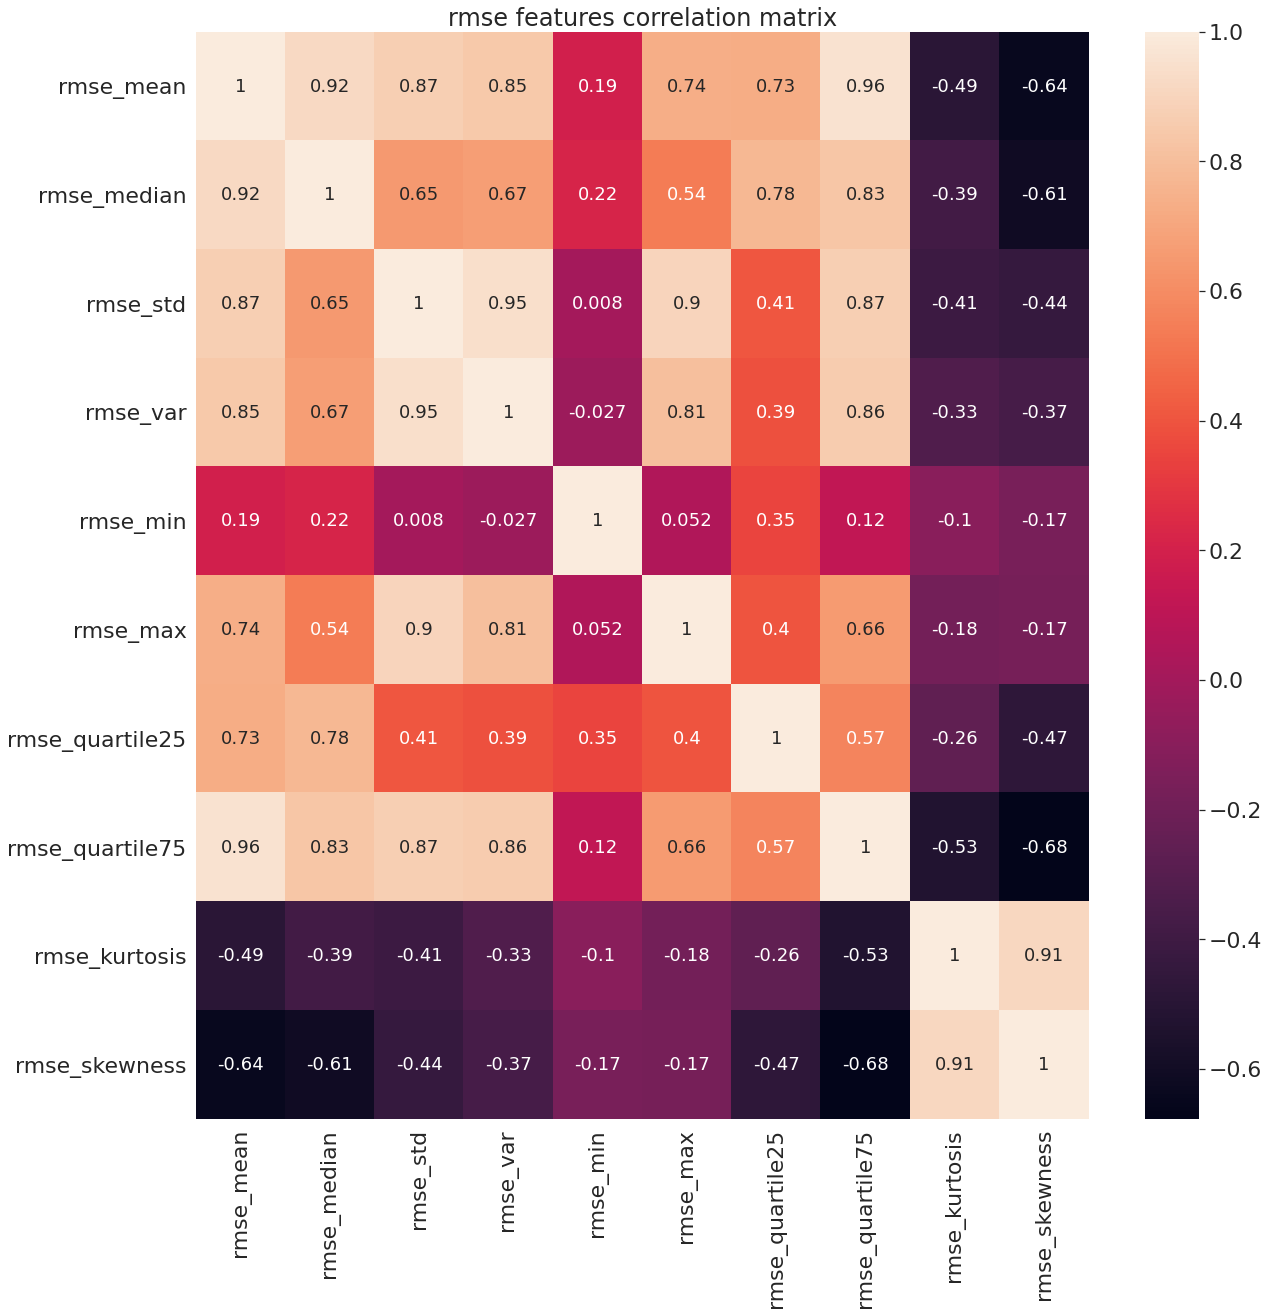

In [378]:
corrfunction('rmse',data_rmse,col_rmse)

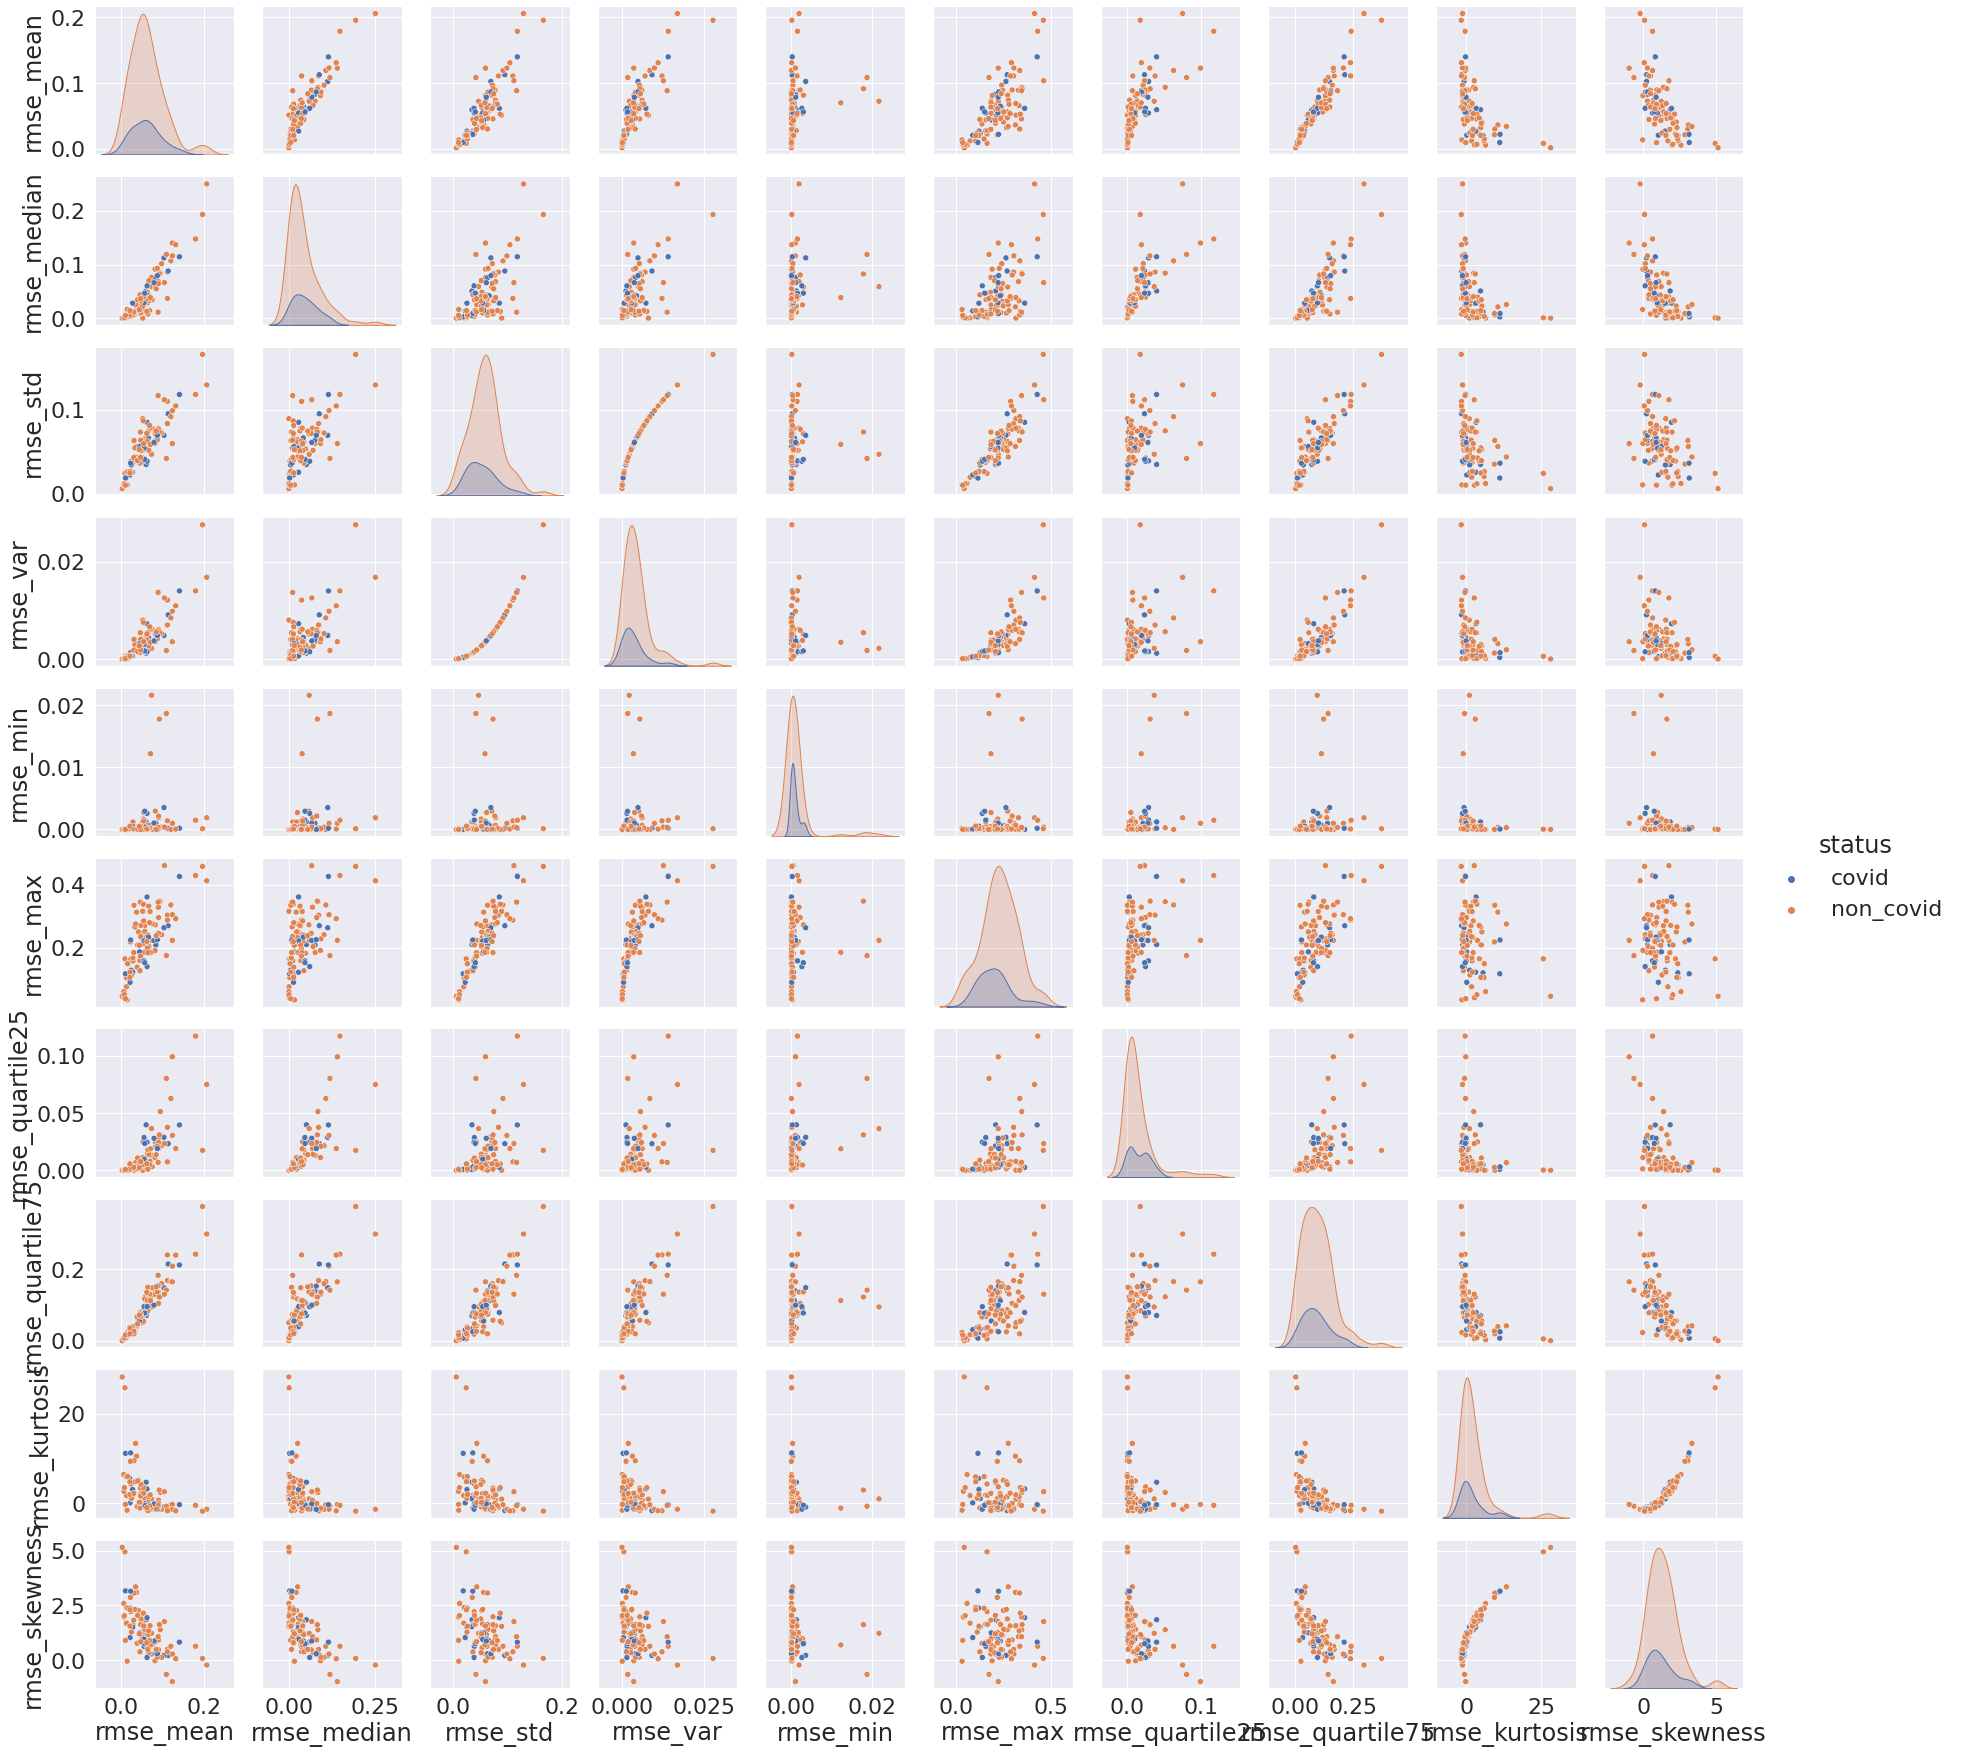

In [379]:
pairplotfunction('rmse',data_rmse)

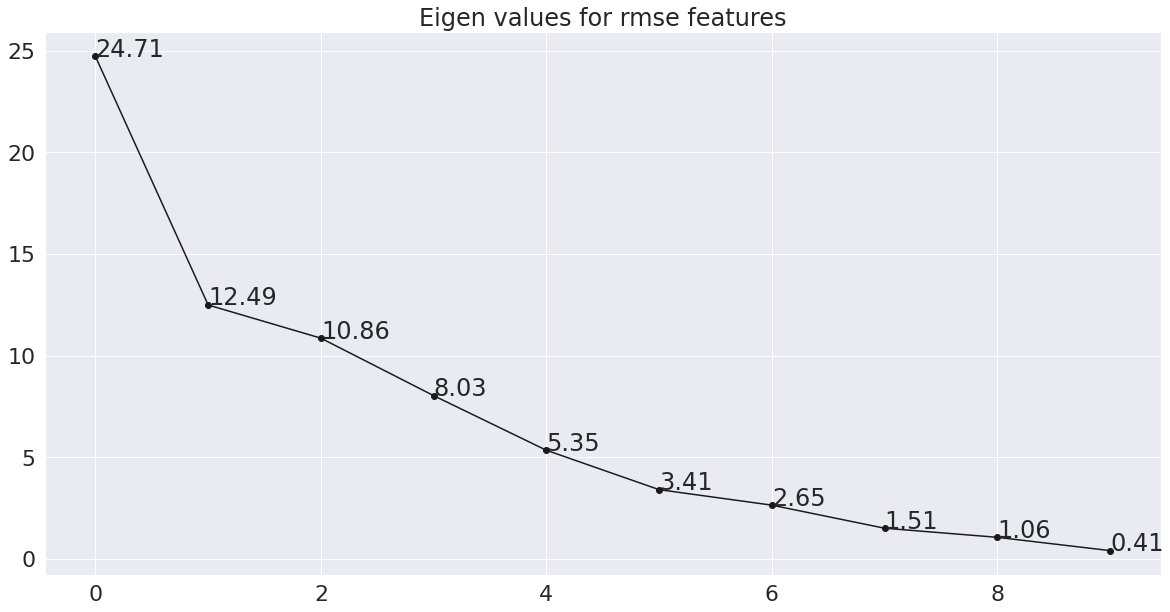

In [380]:
PCAfunction('rmse','rmse')

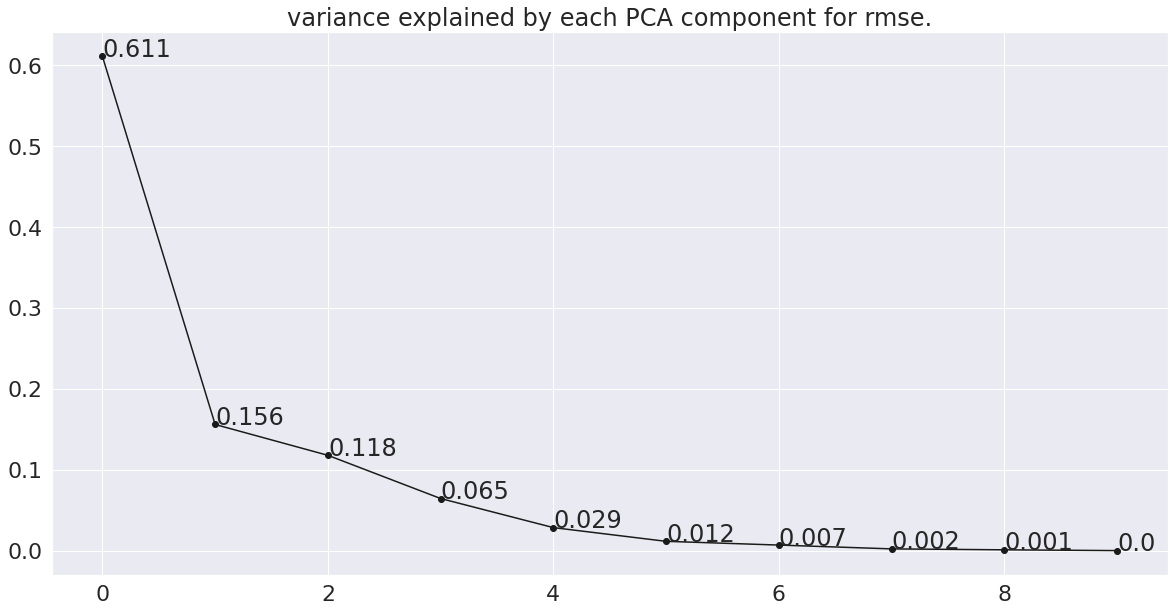

In [381]:
PCAvar('rmse', 'rmse')

Nearly 76% of the variance is explained by the first two components.

In [387]:
sf_pca_df.to_csv('pcasf.csv')
sc_pca_df.to_csv('pcasc.csv')
sr_pca_df.to_csv('pcasr.csv')
rmse_pca_df.to_csv('pcarmse.csv')
zcr_pca_df.to_csv('pcazcr.csv')

## MFCC's and d-MFCC's

The first 13 MFCC coeficcient for each frame is calculated. Delta-MFCC features primarily gives a description of the temporal information in the signal. 


In [447]:
cols = ['ID','status','MFCC0','MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8',
       'MFCC9','MFCC10','MFCC11','MFCC12']
dcols = ['ID','status','dMFCC0','dMFCC1','dMFCC2','dMFCC3','dMFCC4','dMFCC5','dMFCC6','dMFCC7','dMFCC8',
       'dMFCC9','dMFCC10','dMFCC11','dMFCC12']
mfcc_df = pd.DataFrame(columns=cols)
dmfcc_df = pd.DataFrame(columns=dcols)
mfcc_df[['ID','status']] = d[['ID','status']]
dmfcc_df[['ID','status']] = d[['ID','status']]


In [449]:
for idno in range(len(id_list)):
    with open(all_files_js[idno]) as jsonfile:
        da = js.load(jsonfile)
    del da['vol']
    del da['stage']
    del da['cont']
    del da['annotator_name']
    del da['quality']
    mfccavg =np.zeros(13)
    dmfccavg =np.zeros(13)
    l=0
    y, sr = librosa.load(audio_files[idno], sr = 16000)
    for l in range(int(len(da)/2)):
        mfcc = []
        dmfcc = []
        MFCC = (librosa.feature.mfcc(y=y[math.ceil(da['start_{}'.format(l+1)]*sr):math.ceil(sr*da['end_{}'.format(l+1)])],sr=sr,n_fft=256, hop_length=128, n_mfcc = 13, n_mels=64))
        dMFCC = librosa.feature.delta(MFCC)
        for i in range(13):
            mfcc = mfcc + [sum(list(MFCC[i]))/len(list(MFCC[i]))]
            dmfcc = dmfcc + [sum(list(dMFCC[i]))/len(list(dMFCC[i]))]
        mfcc=np.asarray(mfcc)
        dmfcc=np.asarray(dmfcc)
        mfccavg = (mfccavg+mfcc)*0.5
        dmfccavg = (dmfccavg+dmfcc)*0.5
        
    for i in range(13):
        mfcc_df['MFCC{}'.format(i)][idno] = mfccavg[i]
        dmfcc_df['dMFCC{}'.format(i)][idno] = dmfccavg[i]




In [452]:
mfcc_df.to_csv('MFCCfeatures.csv')
dmfcc_df.to_csv('dMFCCfeatures.csv')

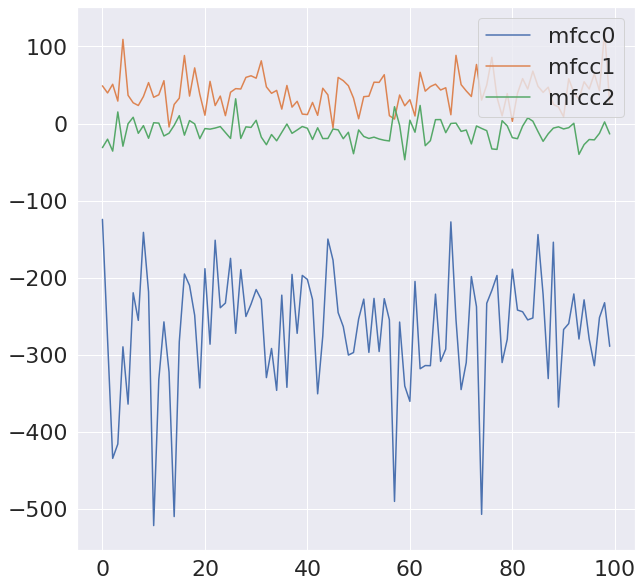

In [505]:
plt.figure(figsize=(10,10))
plt.plot(mfcc_df['MFCC0'], label = 'mfcc0')
plt.plot(mfcc_df['MFCC1'], label = 'mfcc1')
plt.plot(mfcc_df['MFCC2'], label = 'mfcc2')
plt.legend(loc = "upper right")b

The MFCC[0] that represents the average energy of the audio signal has negative values for each user ID. This represents that most of the spectral energy for cough is concentrated in higher frequency regions. 

## 1D feature analysis

In [514]:
feature_df_1d=(((((mfcc_df.merge(dmfcc_df, how='outer')).merge(data_sc, how='outer')).merge(data_sr, how='outer')
).merge(data_zcr, how='outer')).merge(data_rmse, how='outer')).merge(data_sf, how='outer')
feature_names=(feature_df_1d.columns[2:])
feature_df_1D = feature_df_1d[feature_names]
feature_df_1D = feature_df_1D.astype(float)
feature_matrix_1D=feature_df_1D.to_numpy()


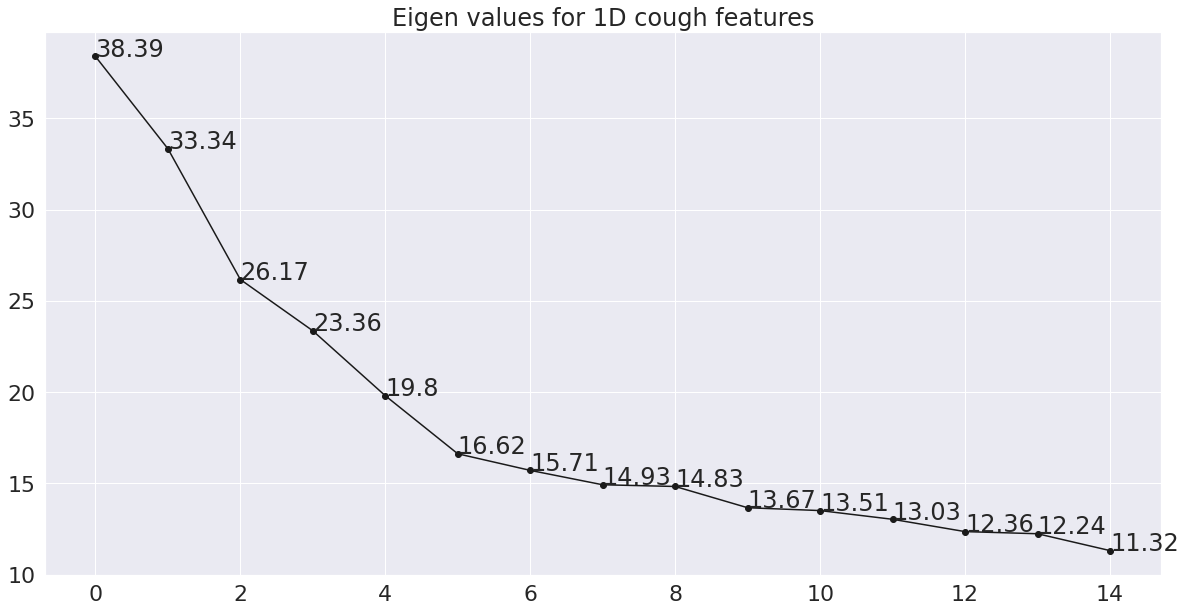

In [515]:
features_scaled = StandardScaler().fit_transform(feature_matrix_1D)
features_scaled_df = pd.DataFrame(features_scaled, columns=feature_names)
pca = PCA(n_components=15)
principal_comps=pca.fit_transform(features_scaled)
#features1D_pca_df = pd.DataFrame(data=principal_comps, columns=['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7','PCA8','PCA9','PCA10'])
pcavar_features=pca.explained_variance_ratio_
ev_features= pca.singular_values_
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(ev_features ,color='k', marker='o')
for num in range(len(ev_features)):
    plt.annotate(round(ev_features[num],2),(num, ev_features[num]))
plt.title('Eigen values for 1D cough features')
plt.savefig('PCA1D_featuresEigVal.png')
plt.show()


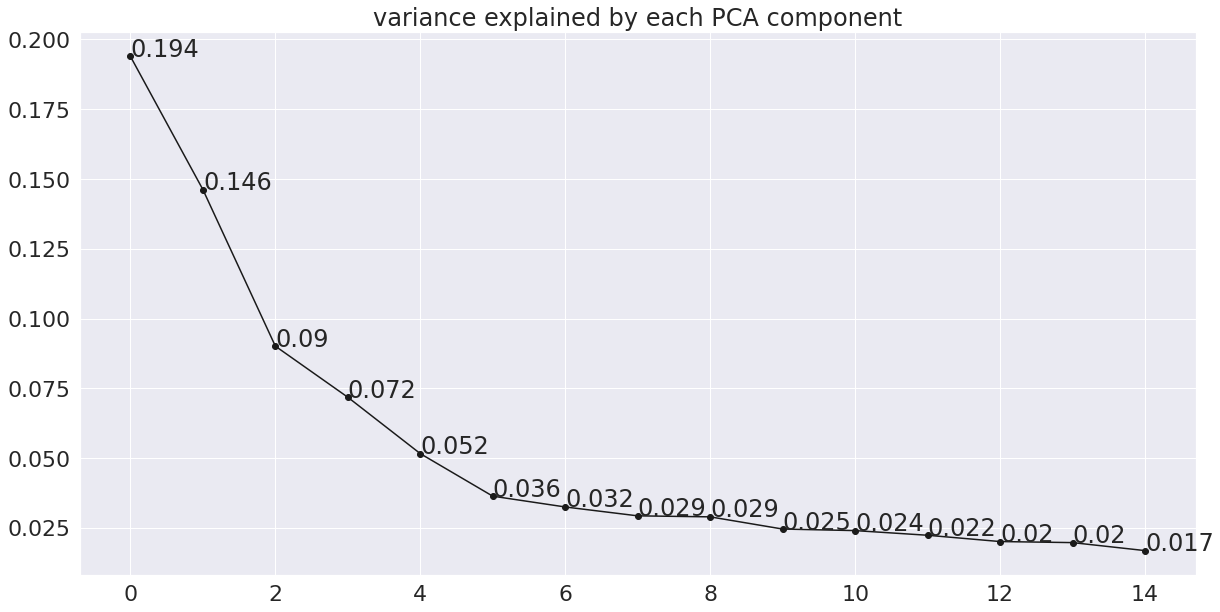

In [516]:
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(pcavar_features,color='k', marker='o')
for num in range(len(pcavar_features)):
    plt.annotate(round(pcavar_features[num],3),(num,pcavar_features[num]))
plt.title('variance explained by each PCA component')
plt.savefig('PCAvar1Dfeatures.png')
plt.show()

The PCA reduction of the entire feature matrix 100 * 76 gave us components that are not entirely dominant. The first two component hold only 34% of the variation information. 